## TOC:
* [Load anatomical and ROIs](#anat-bullet)
* [Make ROI](#makeroi-bullet)
* [1st level GLM output](#1stlevel-bullet)
* [Individual RDM](#individualrdm-bullet)
* [Group average RDM](#grouprdm-bullet)
* [Model RDM](#modelrdm-bullet)
* [Model comparison](#modelcompare-bullet)

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
import scipy.spatial.distance as sp_distance

import nibabel as nib
import nilearn.plotting as plotting
from nilearn.input_data import NiftiMasker, NiftiSpheresMasker

import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
from nltools.mask import create_sphere

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Autosaving every 5 seconds


In [2]:
base_root = '/home/rj299/scratch60/mdm_analysis/'
data_root = '/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/1stLevel/'
out_root = '/home/rj299/scratch60/mdm_analysis/output/'

## Load anatomical and ROIs <a class="anchor" id="anat-bullet"></a>

In [3]:
anat_mean = nib.load(os.path.join(out_root, 'imaging', 'all_sub_average.nii.gz'))

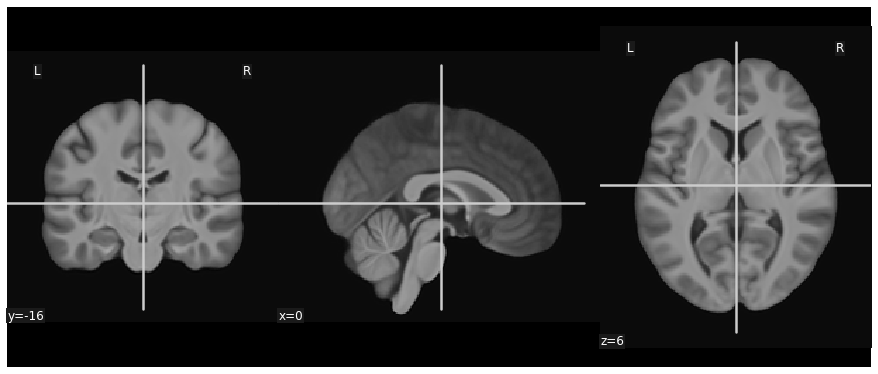

In [4]:
fig = plt.figure(figsize = (12,5))
plotting.plot_anat(anat_mean, black_bg = True, figure = fig)

In [5]:
# Masker files
maskfile_vmpfc = os.path.join(out_root,'imaging', 'binConjunc_PvNxDECxRECxMONxPRI_vmpfc.nii.gz')
maskfile_vstr = os.path.join(out_root,'imaging', 'binConjunc_PvNxDECxRECxMONxPRI_striatum.nii.gz')
mask_file_rppf = os.path.join(out_root,'imaging', 'Gilaie-DotanEtAl_2014_Study1_rPPC-NScorr-Thres250Voxels_roi.nii')
maskfile_roi1 = os.path.join(out_root,'imaging', 'none_glm_Med_Mon_TFCE_p001_roi1.nii.gz')
maskfile_roi2 = os.path.join(out_root,'imaging', 'none_glm_Med_Mon_TFCE_p001_roi2.nii.gz')
maskfile_roi3 = os.path.join(out_root,'imaging', 'none_glm_Med_Mon_TFCE_p001_roi3.nii.gz')

maskfiles = {'vmpfc': maskfile_vmpfc, 
             'vstr': maskfile_vstr, 
             'rppc': mask_file_rppf,
             'med_mon_1': maskfile_roi1, 
             'med_mon_2': maskfile_roi2, 
             'med_mon_3': maskfile_roi3}

# roi inputs are loaded images
all_masks = {key_name: nib.load(maskfiles[key_name]) for key_name in maskfiles.keys()}

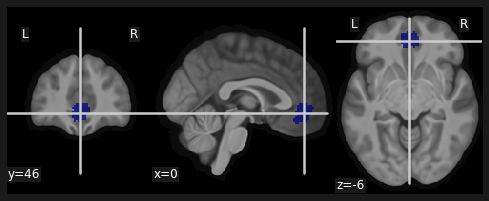

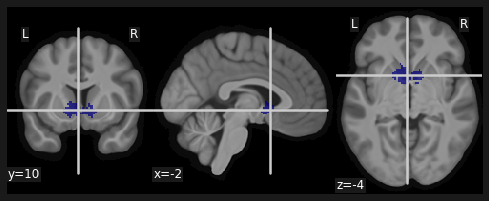

In [6]:
plotting.plot_roi(all_masks['vmpfc'], bg_img = anat_mean)
plotting.plot_roi(all_masks['vstr'], bg_img = anat_mean)

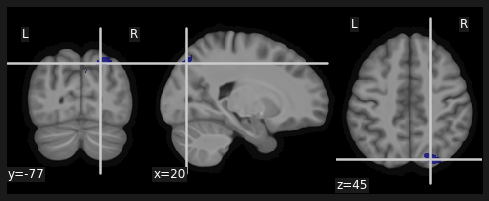

In [7]:
plotting.plot_roi(all_masks['rppc'], bg_img = anat_mean)

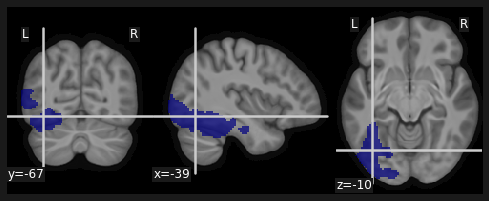

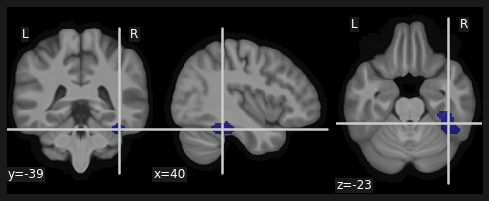

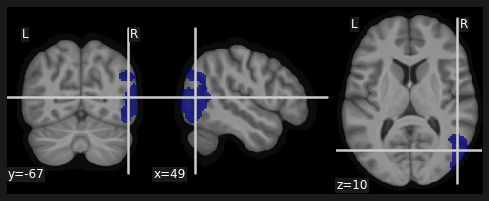

In [5]:
plotting.plot_roi(all_masks['med_mon_1'], bg_img = anat_mean)
plotting.plot_roi(all_masks['med_mon_2'], bg_img = anat_mean)
plotting.plot_roi(all_masks['med_mon_3'], bg_img = anat_mean)

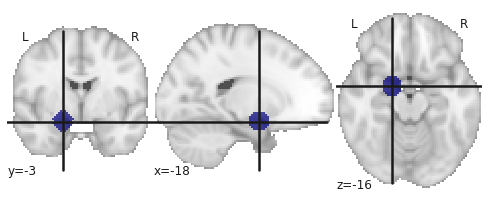

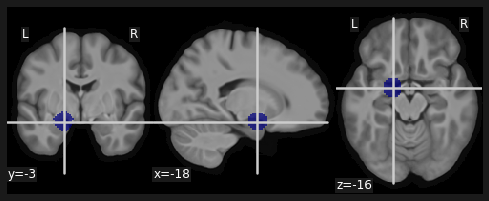

In [8]:
plotting.plot_roi('/home/rj299/scratch60/mdm_analysis/output/imaging/levy_jn_2010_ambig_sphere_lamyg.nii.gz')
plotting.plot_roi('/home/rj299/scratch60/mdm_analysis/output/imaging/levy_jn_2010_ambig_sphere_lamyg.nii.gz', anat_mean)


In [9]:
mask = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/levy_jn_2010_ambig_sphere_lamyg.nii.gz')

## Make ROI mask based on center coordinates <a class="anchor" id="makeroi-bullet"></a>

In [30]:
cluster_size = 900
cube_len = cluster_size ** (1/3)
print('Cube length = %s' %cube_len)

Cube length = 9.654893846056297


In [25]:
# Zhihao's paper

coords_zhang_val = [[-35, -64, 52],
              [35, 39, 0],
              [-25, 52, -6],
              [18, -83, 0]]

labels_zhang_val = [
    'lppc',
    'rofc',
    'lofc',
    'lingual'
    ]

coords_zhang_sal = [[-15, 40, 16],
                    [-36, -26, 52],
                    [-10, 7, 6],
                    [11, 8, 6],
                    [38, 16, -1],
                    [-39, 20, 6],
                    [-11, -63, 1]
                   ]

labels_zhang_sal = [
    'acc',
    'lprecentral',
    'lcaudate',
    'rcaudate',
    'rinsula',
    'linsula',
    'lingual'
    ]

rad = 7


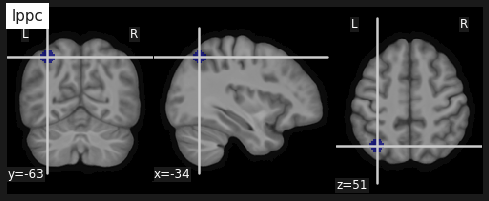

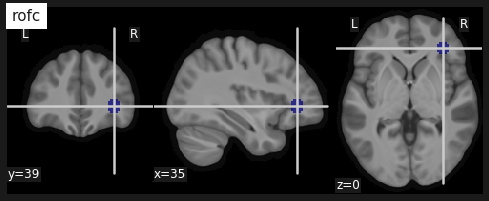

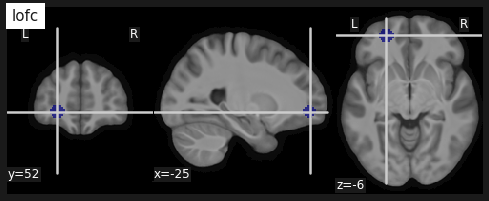

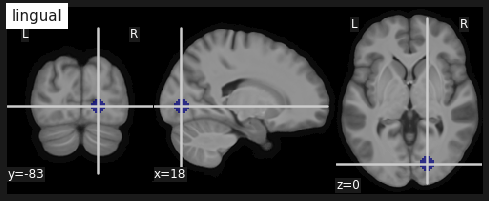

In [27]:
for mask_idx, mask_name in enumerate(labels_zhang_val):
    
    mask = create_sphere(coords_zhang_val[mask_idx], radius = rad)
    plotting.plot_roi(mask, anat_mean, title = mask_name)
    
    # save
    mask.to_filename(os.path.join(out_root, 'imaging', 'zhang_nn_2017_value_sphere_%s.nii.gz' %mask_name))

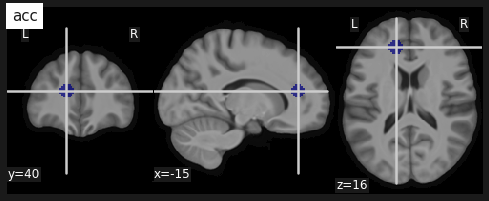

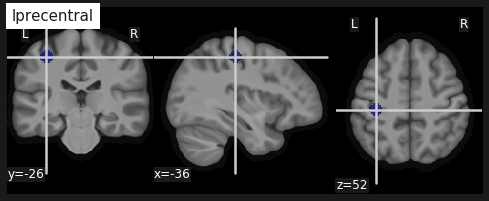

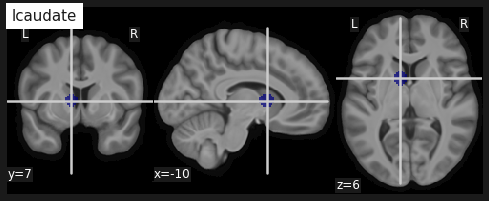

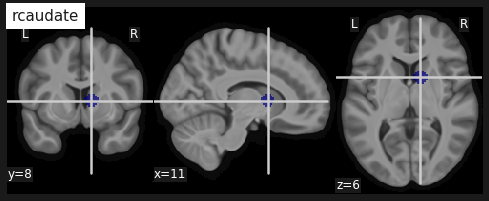

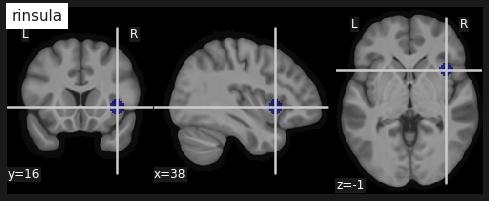

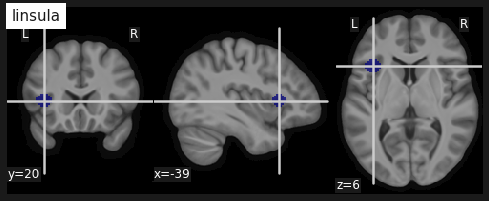

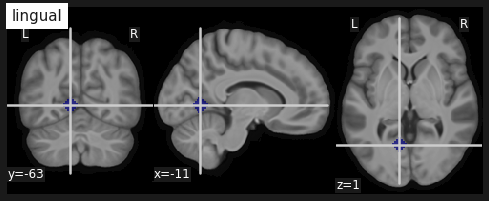

In [29]:
for mask_idx, mask_name in enumerate(labels_zhang_sal):
    
    mask = create_sphere(coords_zhang_sal[mask_idx], radius = rad)
    plotting.plot_roi(mask, anat_mean, title = mask_name)
    
    # save
    mask.to_filename(os.path.join(out_root, 'imaging', 'zhang_nn_2017_saliency_sphere_%s.nii.gz' %mask_name))

In [6]:
# Ifat's paper

coords_levy_amb = [[0, 13, 7],
                   [2, 43, 15],
                   [-7, -53, 12],
                   [-18, -3, -16],
                   [57, -2, -16],                   
              ]

labels_levy_amb = [
    'striatum', # tailarach 0 11 8
    'mpfc', # 1 40 13
    'pcc', # -6, -51, 14
    'lamyg', # -18 -5 10
    'sts' # 54, -5, -9
    ]

coords_levy_risk = [[-1, 13, 4],
                    [-4, 51, 20],
                   ]

labels_levy_risk = [
    'striatum', # tailarach -1 10 6
    'mpfc', # -4 48 17
    ]

rad = 10

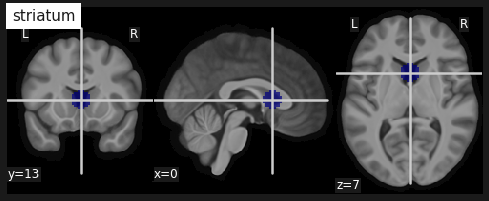

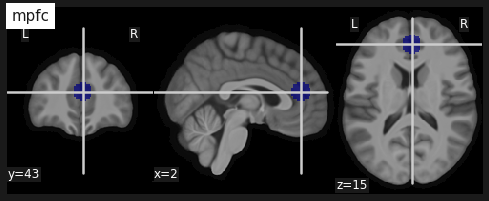

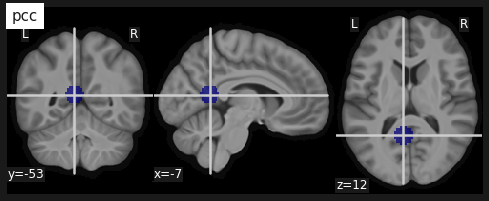

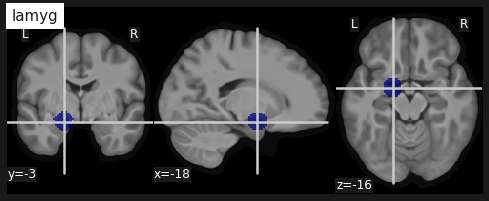

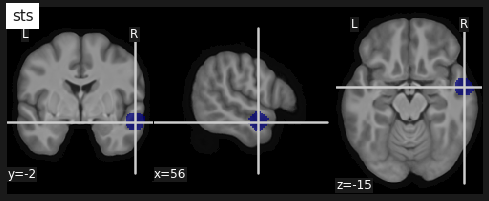

In [7]:
for mask_idx, mask_name in enumerate(labels_levy_amb):
    
    mask = create_sphere(coords_levy_amb[mask_idx], radius = rad)
    plotting.plot_roi(mask, anat_mean, title = mask_name)
    
    # save
    mask.to_filename(os.path.join(out_root, 'imaging', 'levy_jn_2010_ambig_sphere_%s.nii.gz' %mask_name))

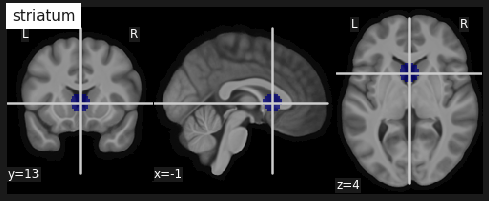

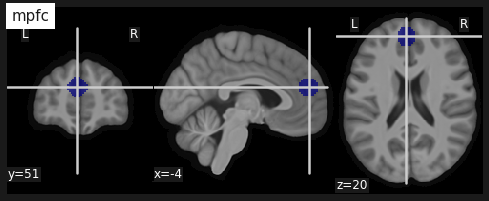

In [33]:
for mask_idx, mask_name in enumerate(labels_levy_risk):
    
    mask = create_sphere(coords_levy_risk[mask_idx], radius = rad)
    plotting.plot_roi(mask, anat_mean, title = mask_name)
    
    # save
    mask.to_filename(os.path.join(out_root, 'imaging', 'levy_jn_2010_risk_sphere_%s.nii.gz' %mask_name))

In [44]:
# # niftishperesmasker does not extract every voxel, it seems to extract an average
# masker_zhang = NiftiSpheresMasker(
#     mni_coords, radius=rad)

# masker_zhang.fit_transform()

## Visualize individual GLM output <a class="anchor" id="1stlevel-bullet"></a>

In [74]:
sub = 2599
# cont1 = nib.load(os.path.join(data_root, '_subject_id_%s' %sub, 'con_0002.nii'))
spmt1 = nib.load(os.path.join(data_root, '_subject_id_%s' %sub, 'spmT_0003.nii'))

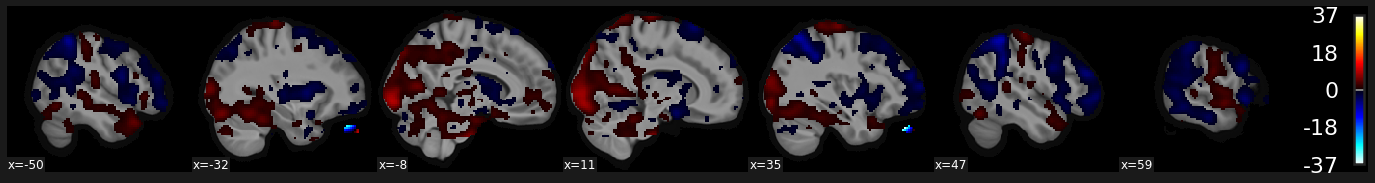

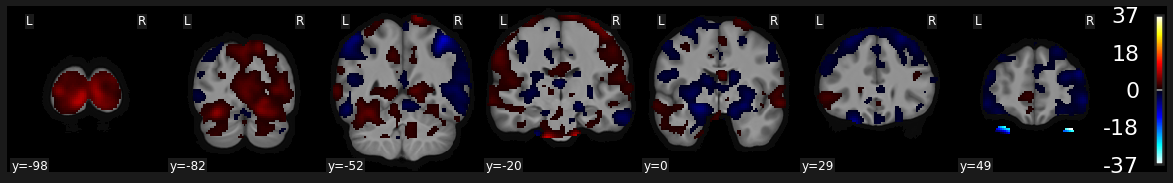

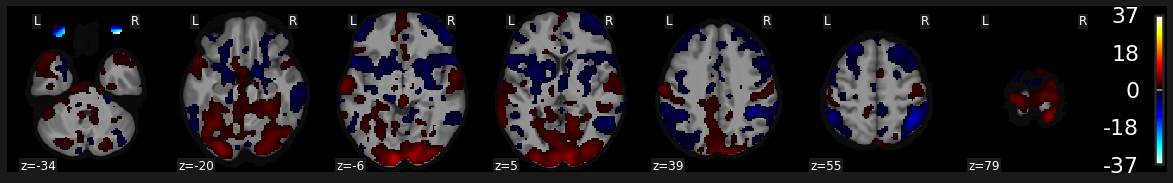

In [72]:
thr = 1
plotting.plot_stat_map(cont1, threshold = thr, bg_img = anat_mean, display_mode = 'x')
plotting.plot_stat_map(cont1, threshold = thr, bg_img = anat_mean, display_mode = 'y')
plotting.plot_stat_map(cont1, threshold = thr, bg_img = anat_mean, display_mode = 'z')

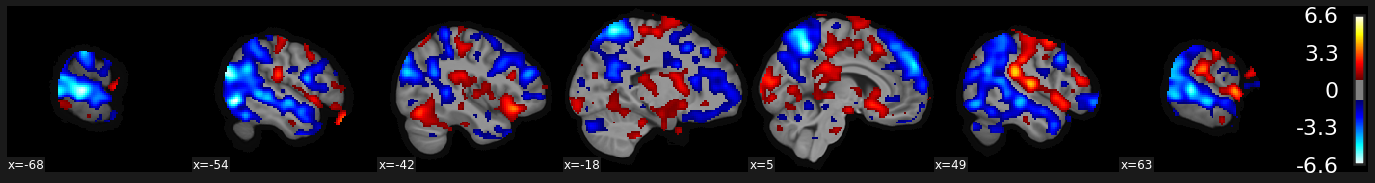

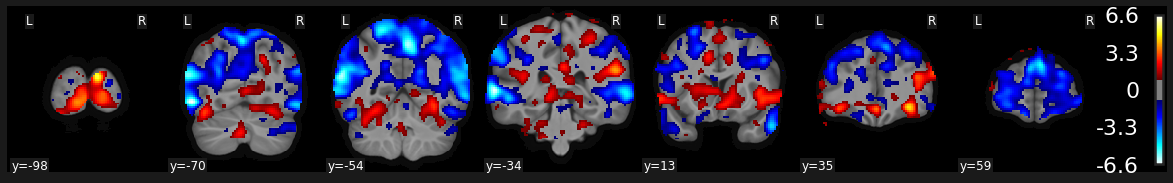

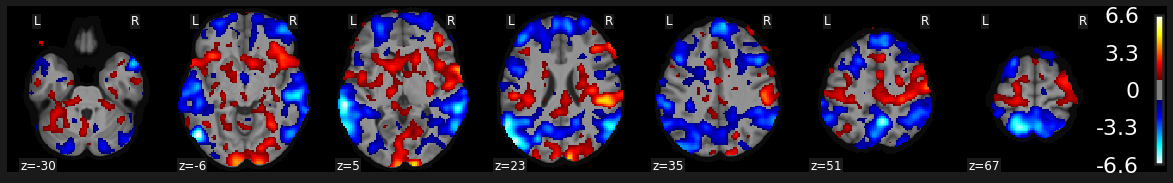

In [75]:
thr = 1
plotting.plot_stat_map(spmt1, threshold = thr, bg_img = anat_mean, display_mode = 'x')
plotting.plot_stat_map(spmt1, threshold = thr, bg_img = anat_mean, display_mode = 'y')
plotting.plot_stat_map(spmt1, threshold = thr, bg_img = anat_mean, display_mode = 'z')

## Visualize individual RDM <a class="anchor" id="individualrdm-bullet"></a>

In [15]:
stims = {'01': 'Med_amb_0', '02': 'Med_amb_1', '03': 'Med_amb_2', '04': 'Med_amb_3',
         '05': 'Med_risk_0', '06': 'Med_risk_1', '07': 'Med_risk_2', '08': 'Med_risk_3', 
         '09': 'Mon_amb_0', '10': 'Mon_amb_1', '11': 'Mon_amb_2', '12': 'Mon_amb_3',
         '13': 'Mon_risk_0', '14': 'Mon_risk_1', '15': 'Mon_risk_2', '16': 'Mon_risk_3'}

stim_num = len(stims)

subjects = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 
            2593, 2594, 2596, 2597, 2598, 2599, 2600, 2624, 
            2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 
            2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666]

In [18]:
# all rois' names
sub = 2654
roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
              allow_pickle = True)
roi_rdm = roi_rdm_obj.item()
roi_names = list(roi_rdm.keys())

print('All names of ROIs:')
for roi_name in roi_names:
    print(roi_name)

All names of ROIs:
vmpfc
vstr
med_mon_1
med_mon_2
med_mon_3
gilaie_rppc
zhang_val_lppc
zhang_val_lofc
zhang_val_lingual
zhang_sal_acc
zhang_sal_lprecentral
zhang_sal_lcaudate
zhang_sal_rcaudate
zhang_sal_linsula
zhang_sal_rinsula
zhang_sal_lingual
levy_amb_striatum
levy_amb_mpfc
levy_amb_ppc
levy_amb_lamyg
levy_amb_sts
levy_risk_striatum
levy_risk_mpfc


In [19]:
sub = 2654
roi_name = 'gilaie_rppc' 

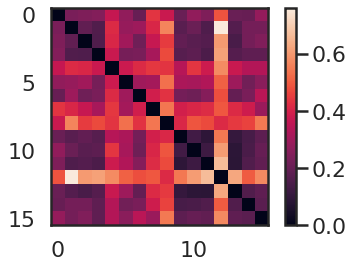

In [20]:
roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
              allow_pickle = True)
roi_rdm = roi_rdm_obj.item()
roi_names = list(roi_rdm.keys())
plt.imshow(roi_rdm[roi_name])
plt.colorbar()

In [ ]:
roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Archive/Sink_rsa/Archive/rdm/_subject_id_%s/roi_rdm.npy' %sub,
              allow_pickle = True)
roi_rdm = roi_rdm_obj.item()
roi_names = list(roi_rdm.keys())
plt.imshow(roi_rdm[roi_name])
plt.colorbar()

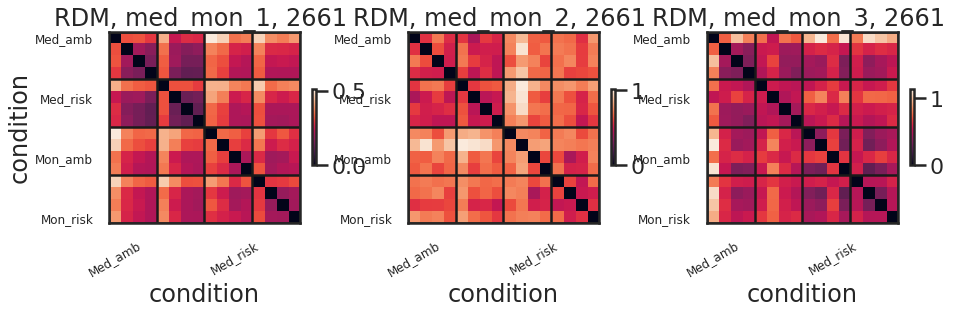

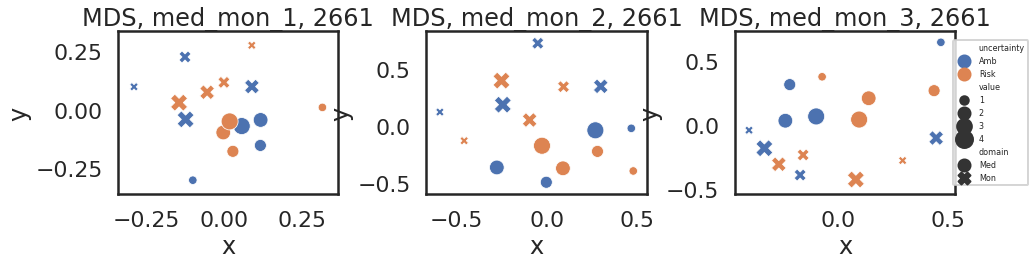

In [27]:
# single subject

# rois to plot
roi_names = ['vmpfc', 'vstr']
roi_names = ['med_mon_1', 'med_mon_2', 'med_mon_3']

subjects = [2661]

for sub in subjects:
    roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
           allow_pickle = True)

    roi_rdm = roi_rdm_obj.item()

    stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
    fontdict = {'fontsize': 12}
    edges = np.array([0,4,8,12,16])-0.5
#     roi_names = list(roi_rdm.keys())

    f, ax = plt.subplots(1,len(roi_names), figsize=(15, 7))

    for roi_idx in range(len(roi_names)):
        im = ax[roi_idx].imshow(roi_rdm[roi_names[roi_idx]])
        ax[roi_idx].set_xticklabels(stim_cat, rotation = 30, fontdict = fontdict)
        ax[roi_idx].set_yticklabels(stim_cat, fontdict = fontdict)
        ax[roi_idx].set_title('RDM, '+roi_names[roi_idx] + ', %s ' %sub) 
        ax[roi_idx].set_xlabel('condition')
        if roi_idx == 0:
            ax[roi_idx].set_ylabel('condition')
        else:
            ax[roi_idx].set_ylabel('')
        ax[roi_idx].vlines(edges,min(edges),max(edges))
        ax[roi_idx].hlines(edges,min(edges),max(edges))
        f.colorbar(im, ax=ax[roi_idx], shrink = 0.5)


    f.subplots_adjust(wspace = 0.25)
    
    f1, ax1 = plt.subplots(1, len(roi_names), figsize=(15, 3))
    
    for (roi_idx, roi_name) in enumerate(roi_names):
        # Create the MDS object
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
        results = mds.fit(roi_rdm[roi_name])

        coords = results.embedding_

        value = [1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4] 
        uncert = ['Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk',
                  'Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk']
        domain = ['Med','Med','Med','Med','Med','Med','Med','Med',
                  'Mon','Mon','Mon','Mon','Mon','Mon','Mon','Mon']

        mds_coord = pd.DataFrame({'x': coords[:,0], 'y': coords[:,1], 'value': value,
                    'uncertainty': uncert, 'domain': domain})    


        sns.scatterplot(x='x', y = 'y',
                        size = 'value', hue = 'uncertainty', style = 'domain',
                        data=mds_coord, legend = 'full',
                        ax = ax1[roi_idx])
        
        if roi_idx == len(roi_names)-1:
            ax1[roi_idx].legend(fontsize = 8, markerscale = 1, loc = 'right', bbox_to_anchor=(1.35, .5))
        else:
            ax1[roi_idx].legend().remove()
            
        ax1[roi_idx].set_title('MDS, ' + roi_name + ', %s' %sub);
        
    f1.subplots_adjust(wspace = 0.4)

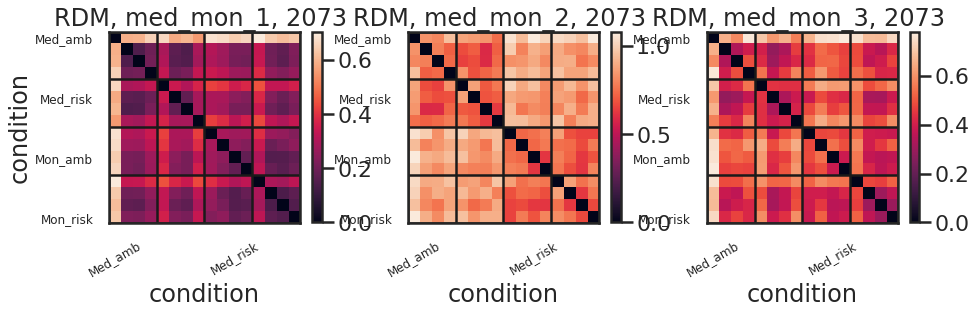

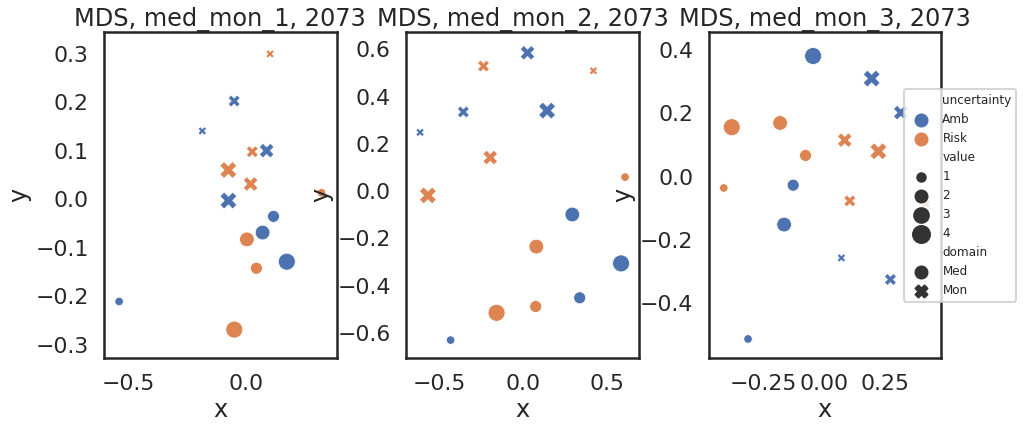

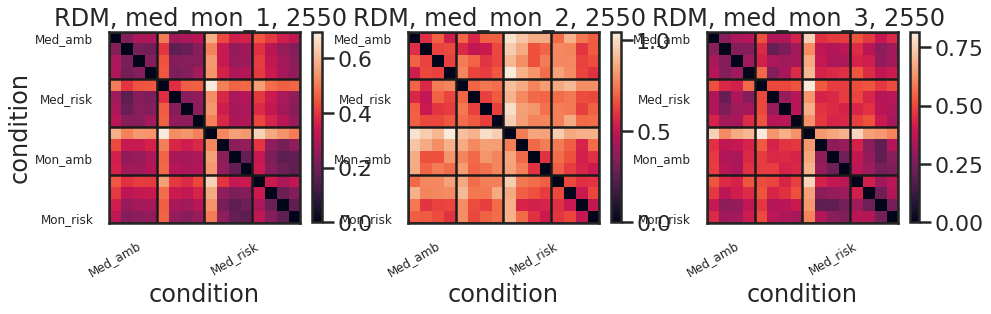

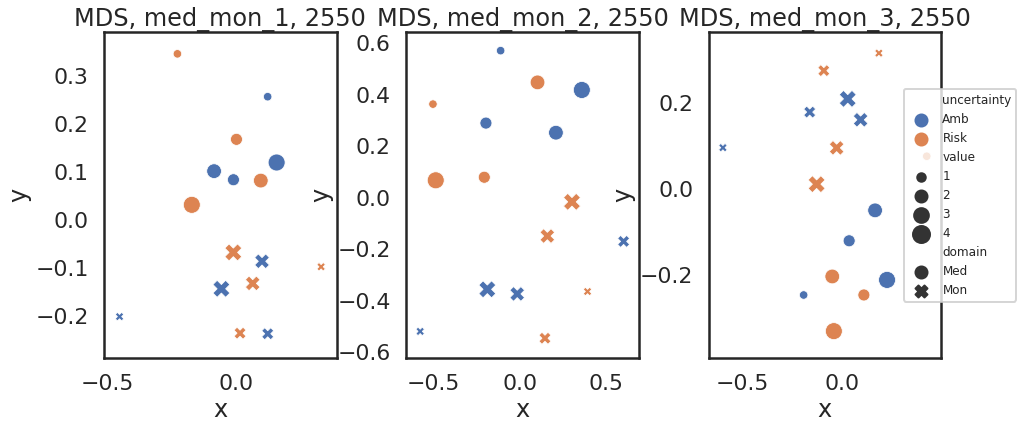

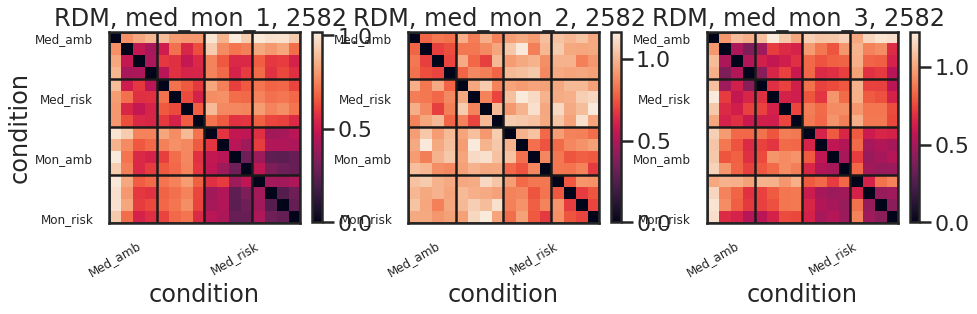

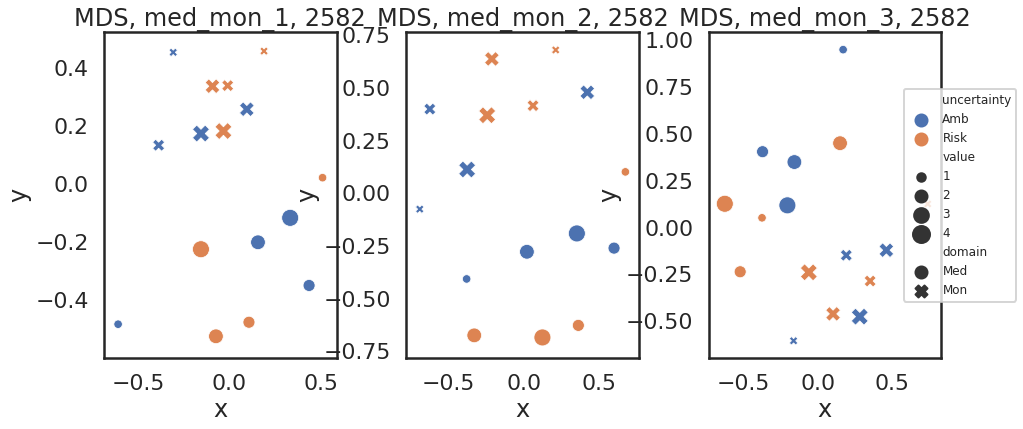

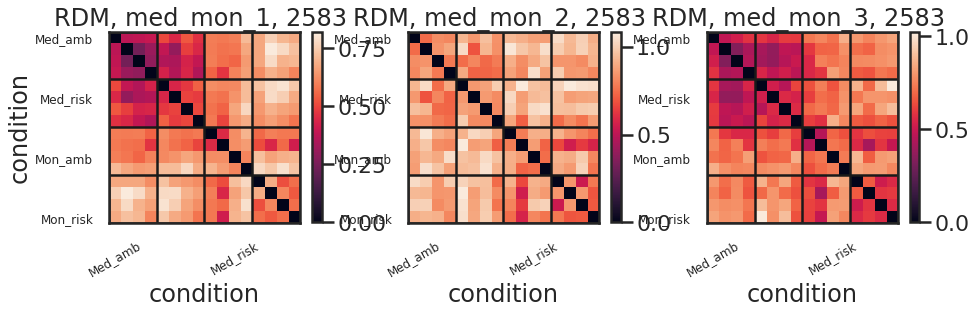

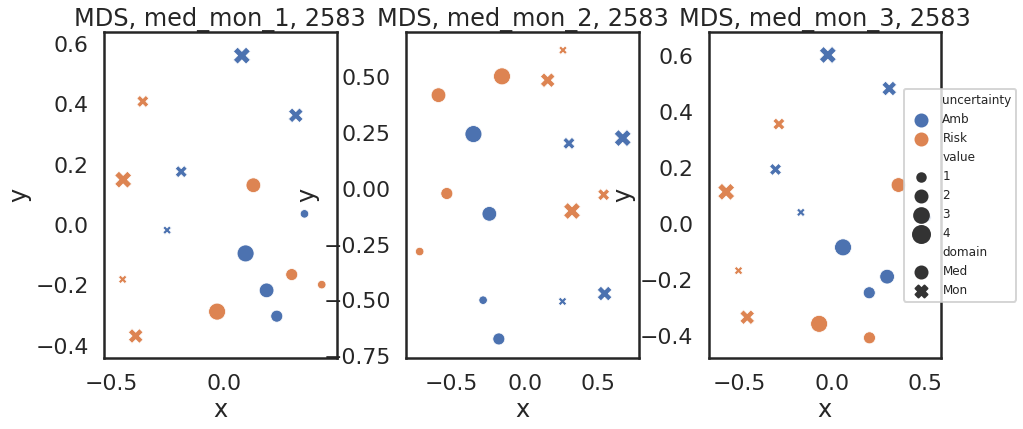

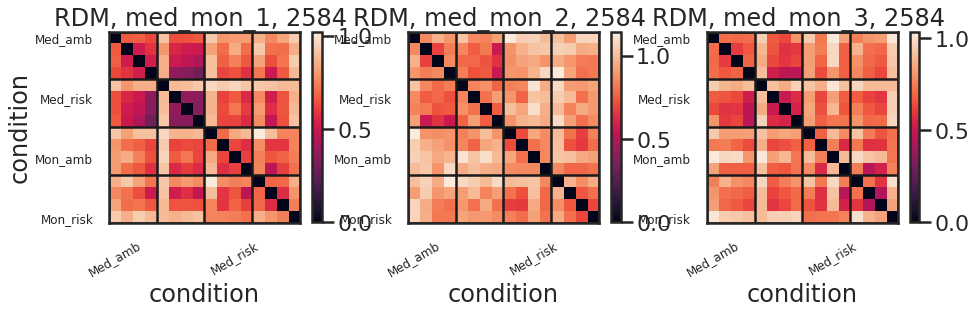

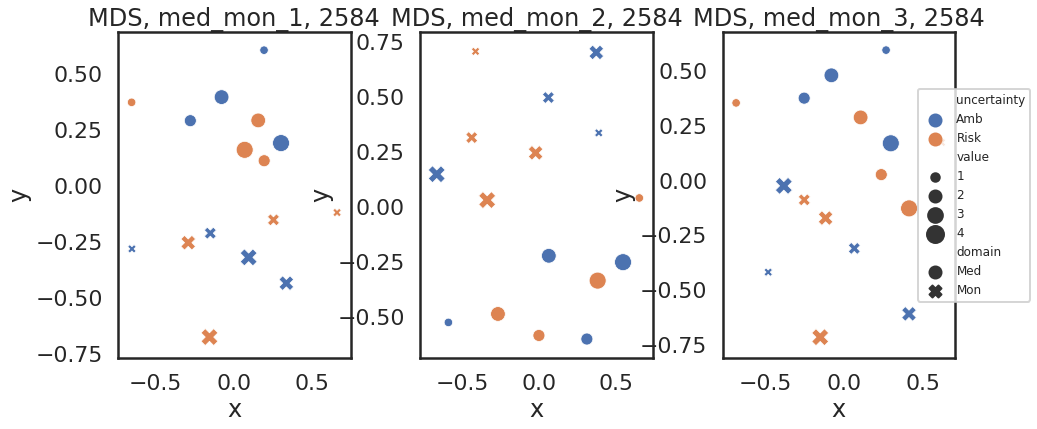

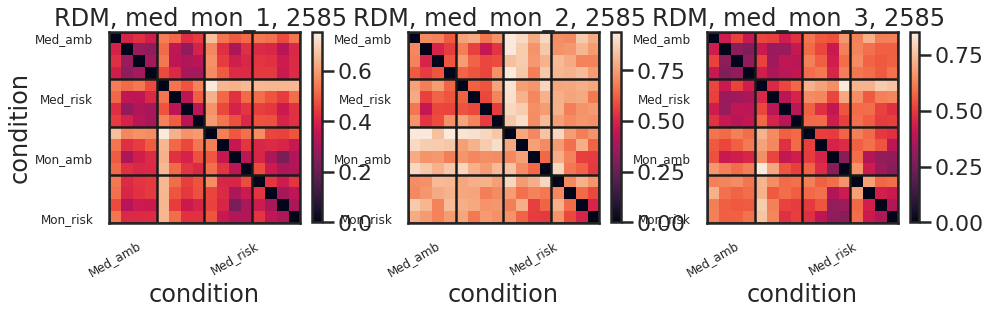

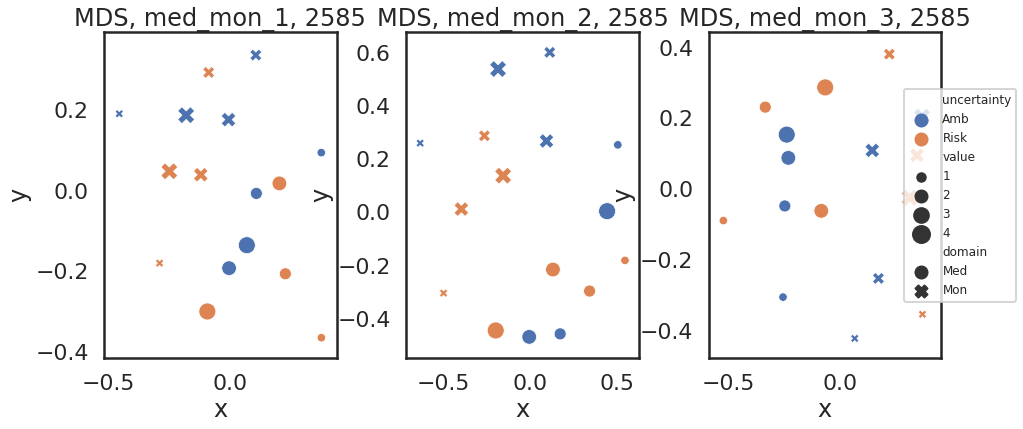

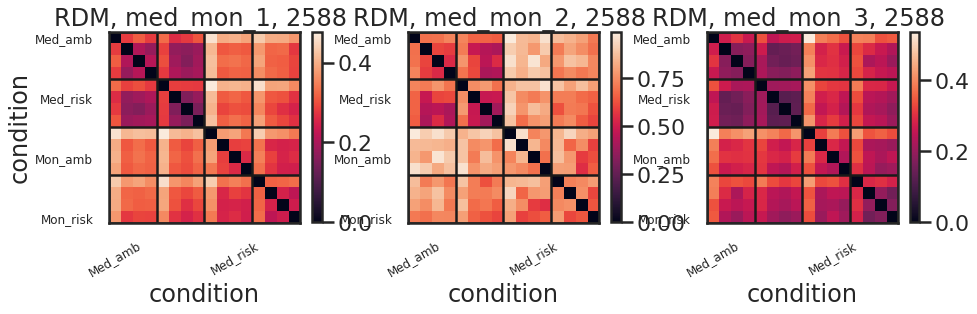

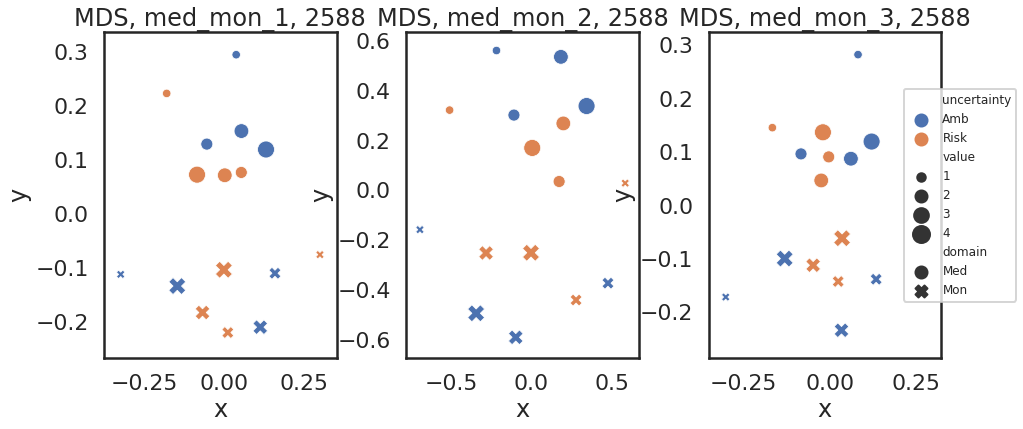

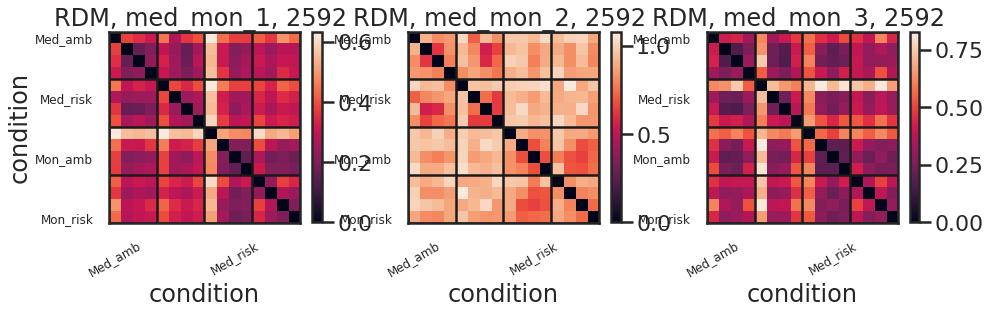

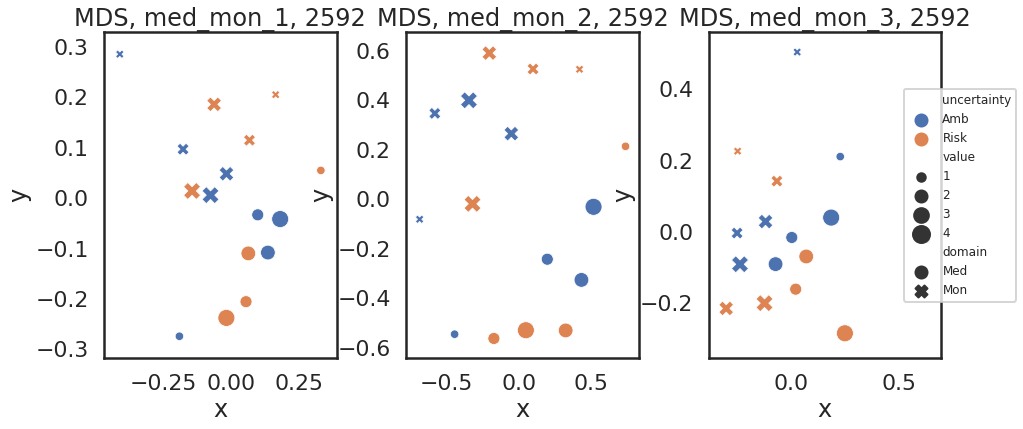

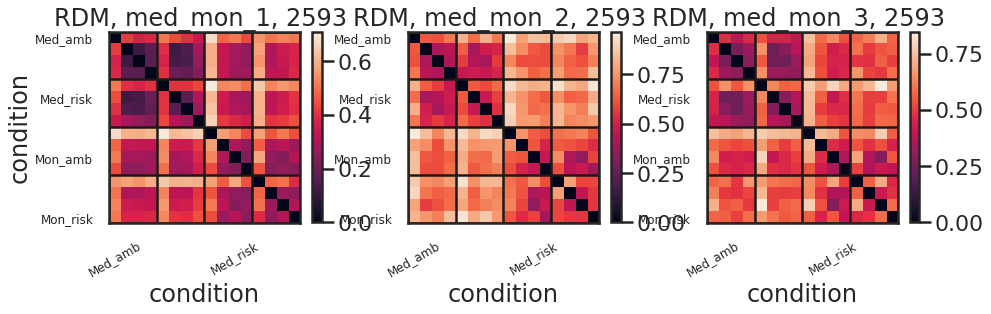

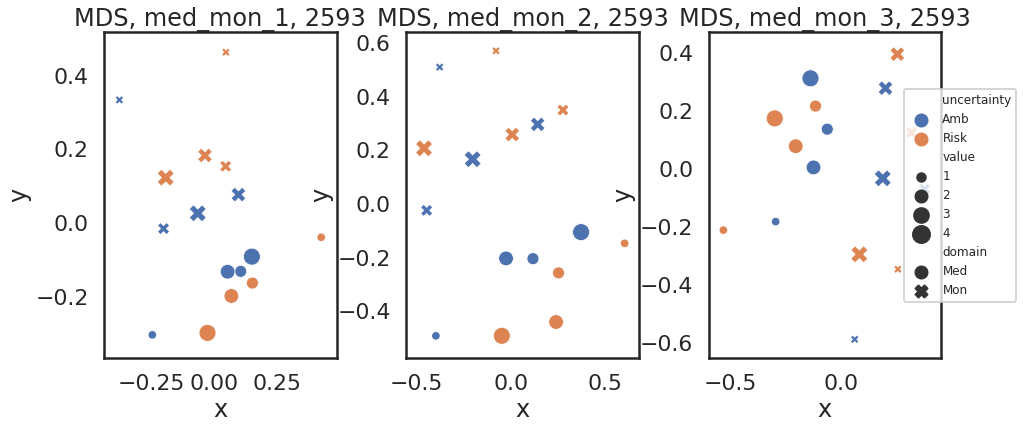

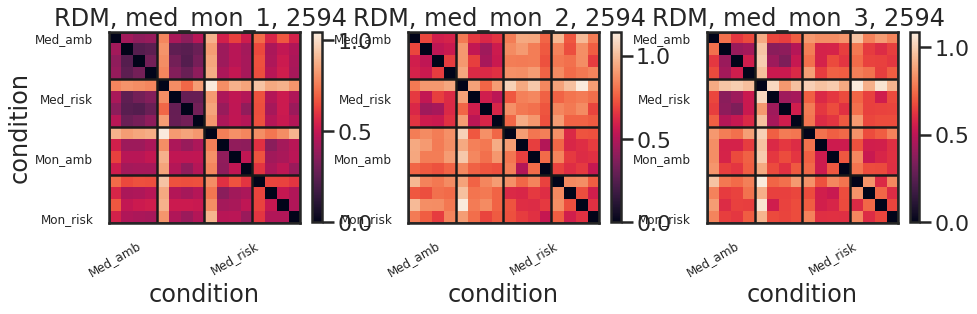

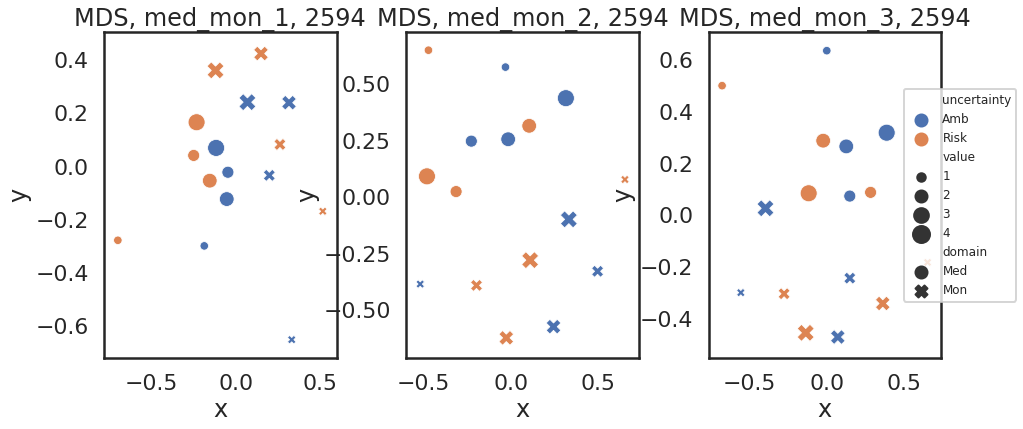

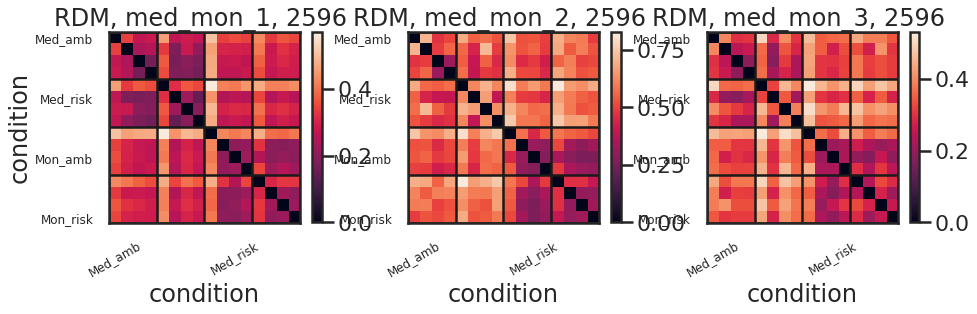

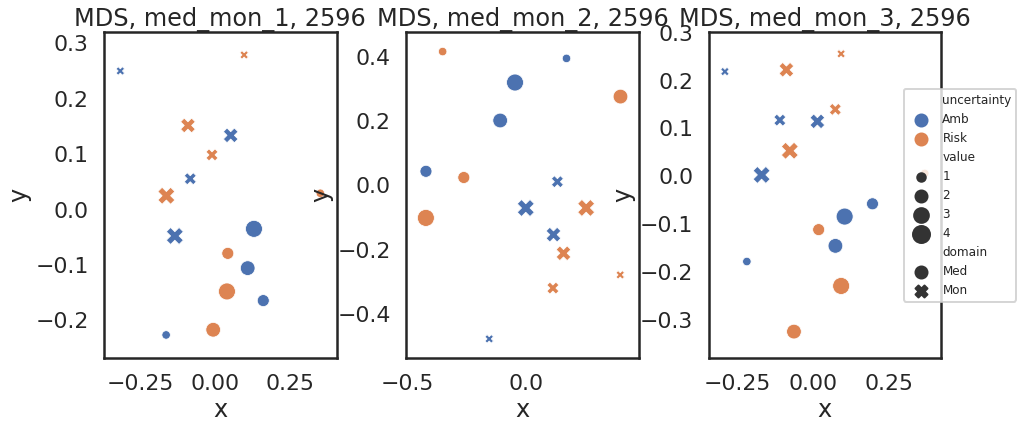

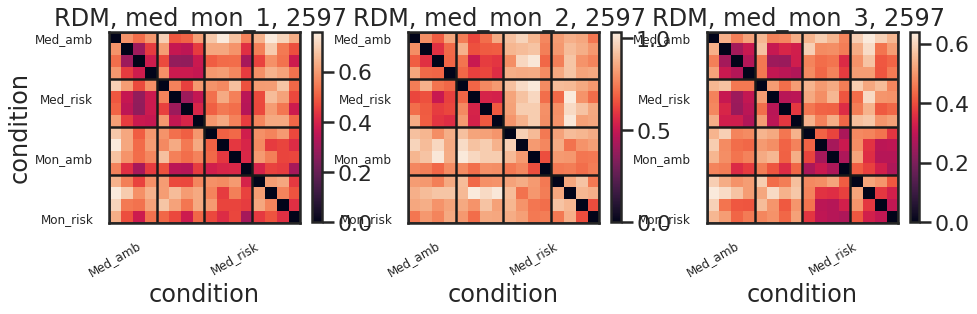

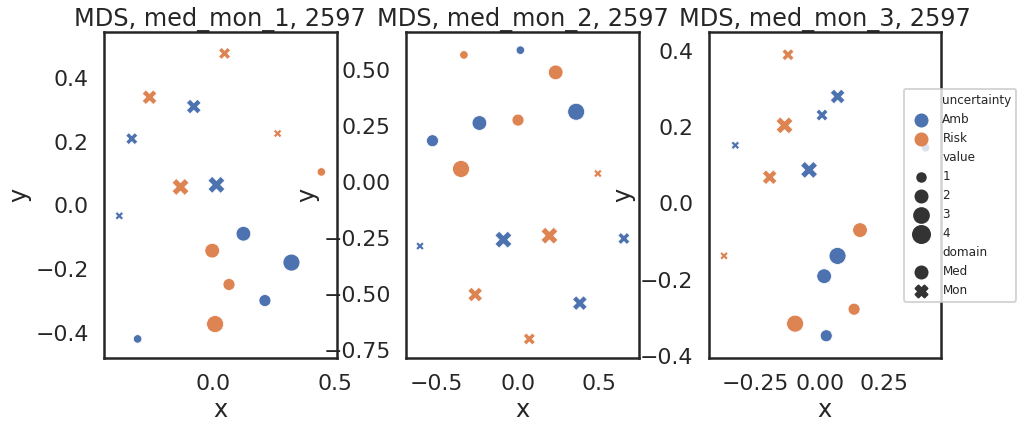

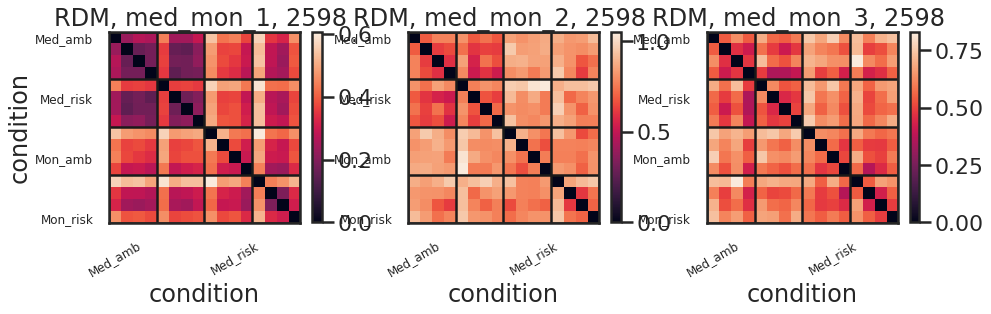

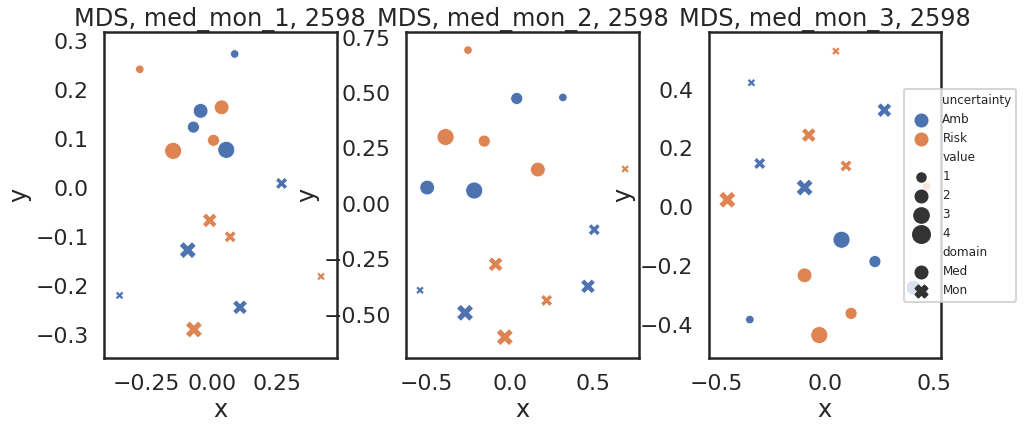

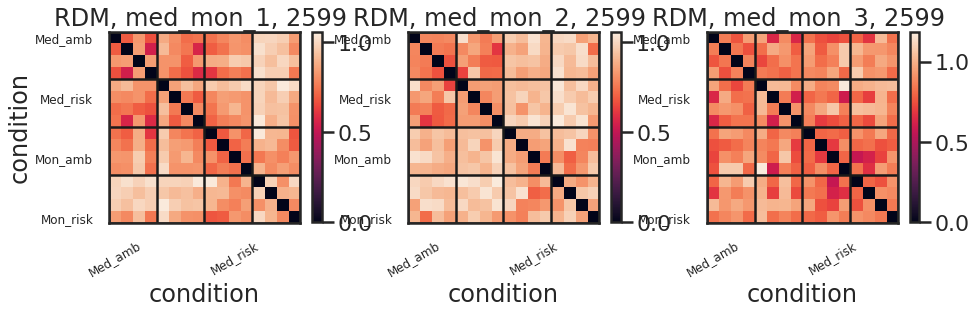

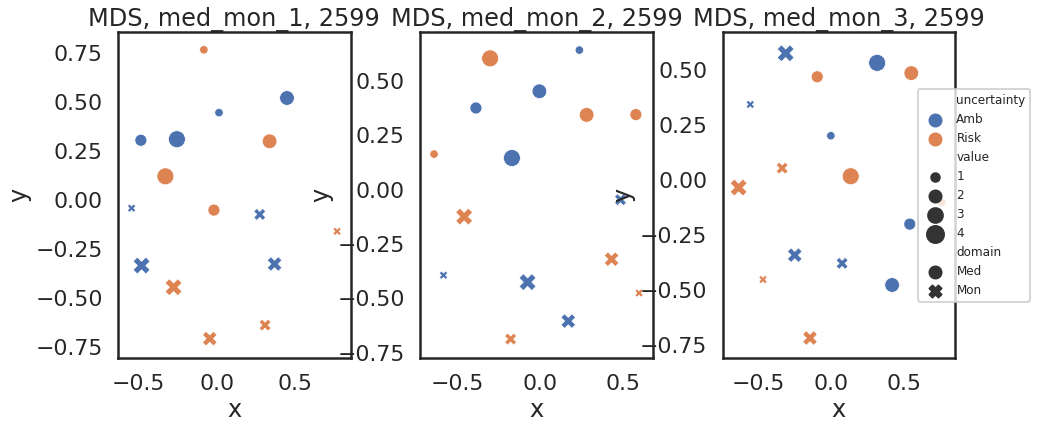

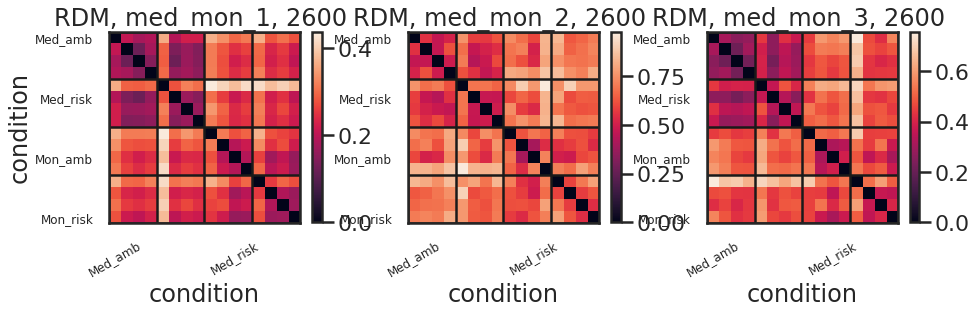

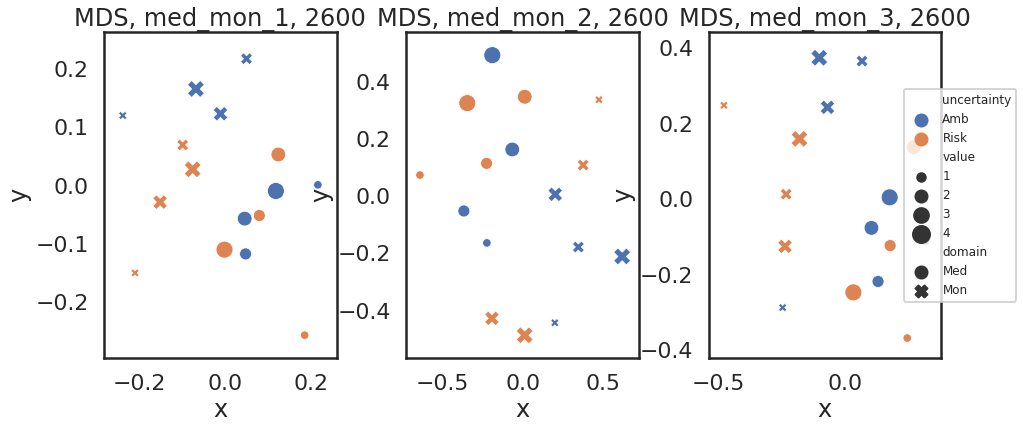

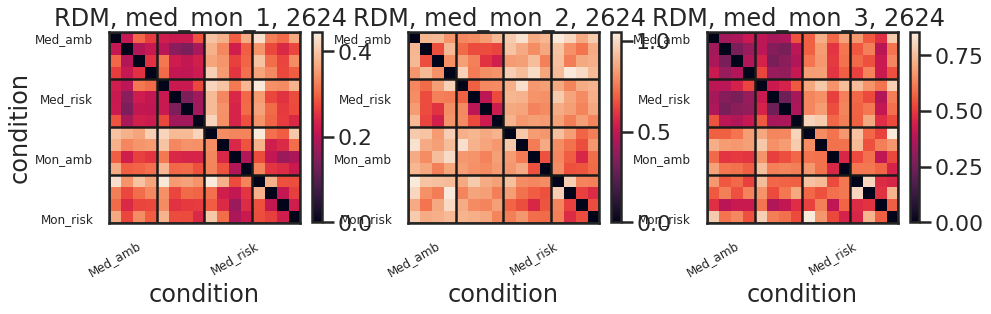

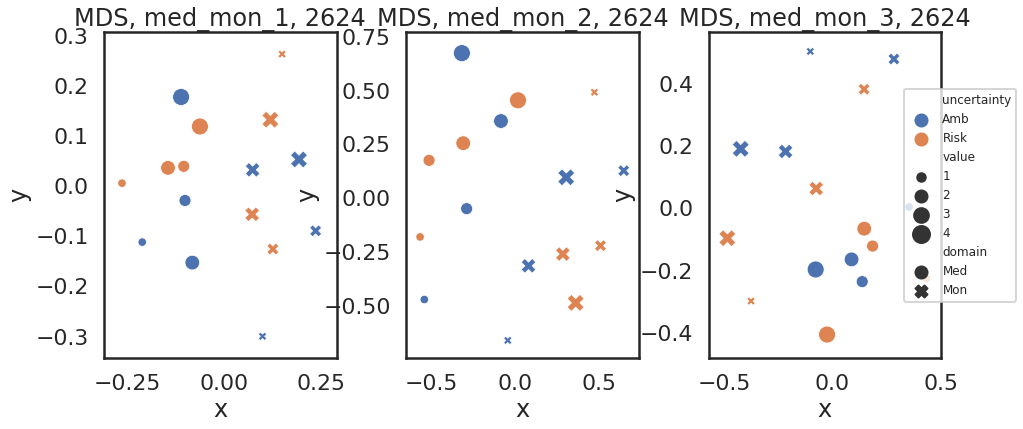

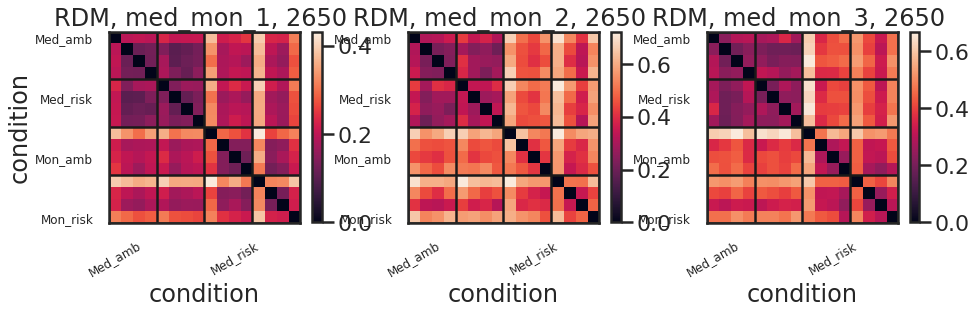

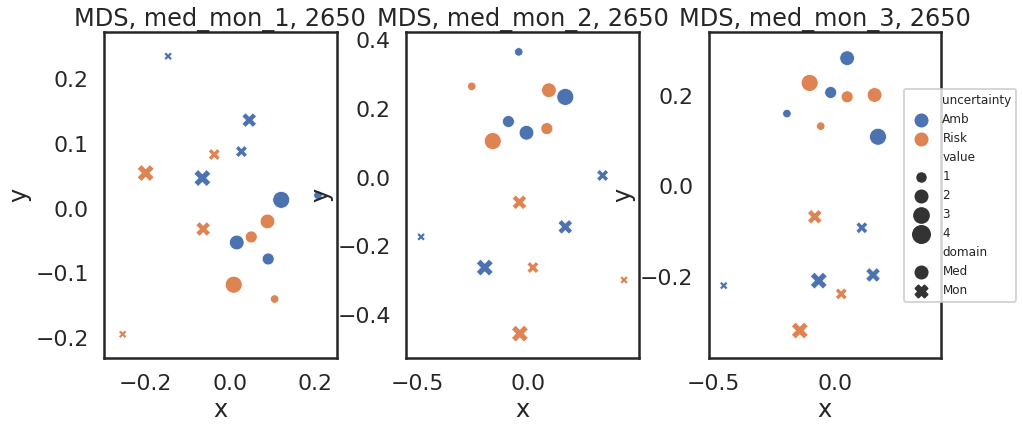

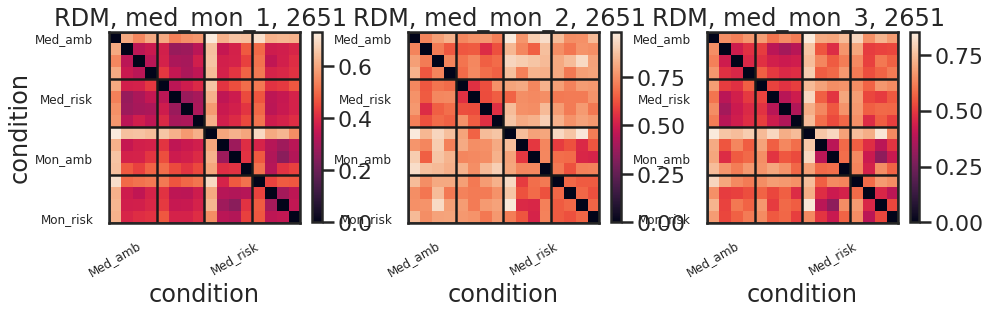

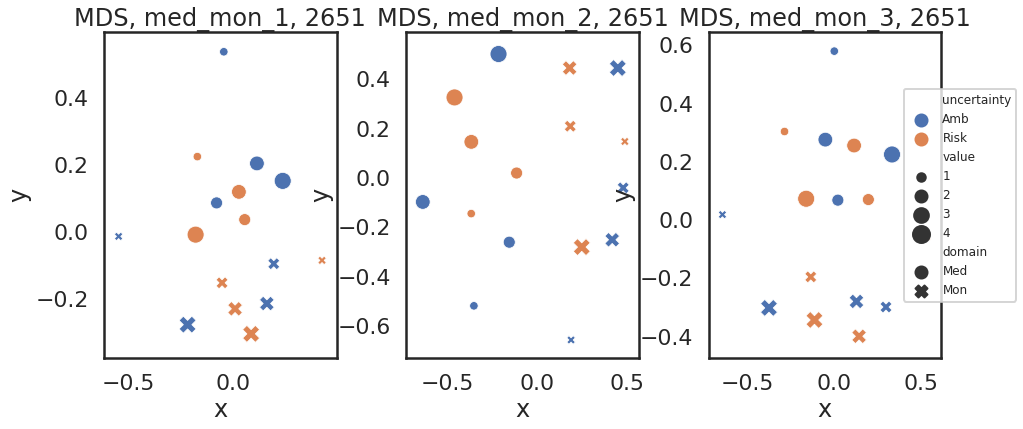

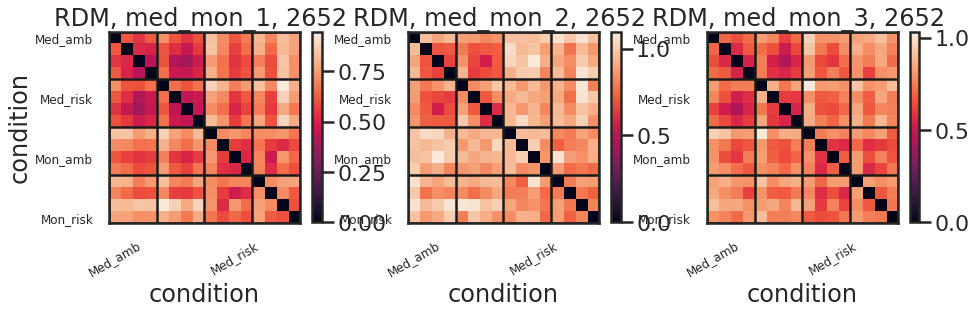

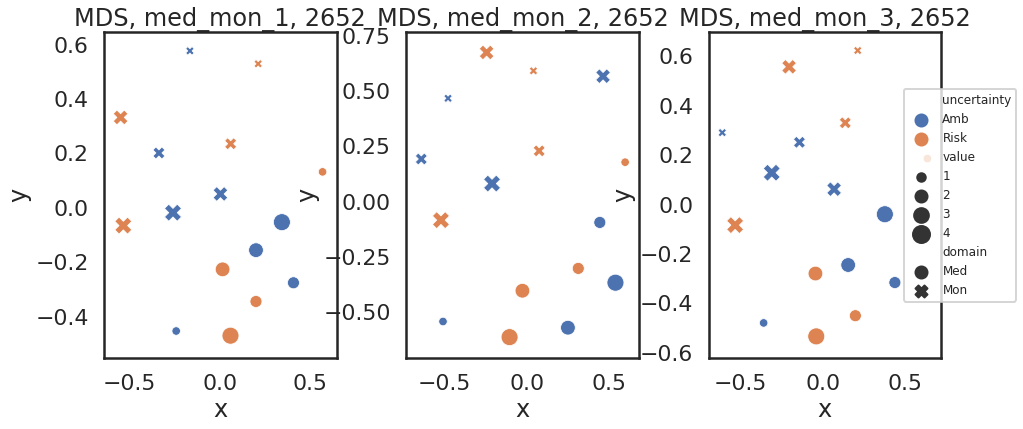

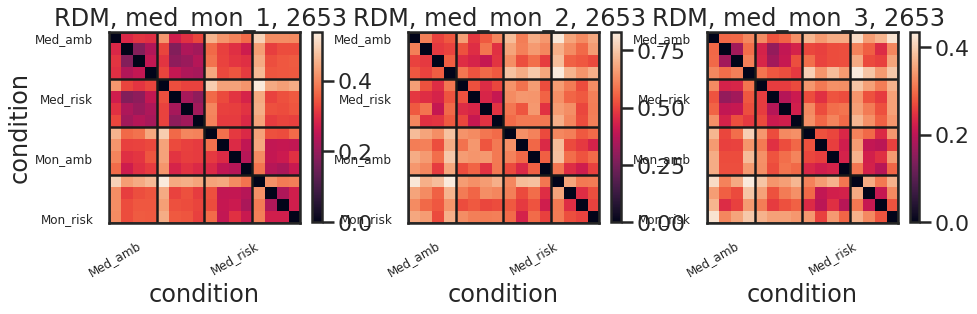

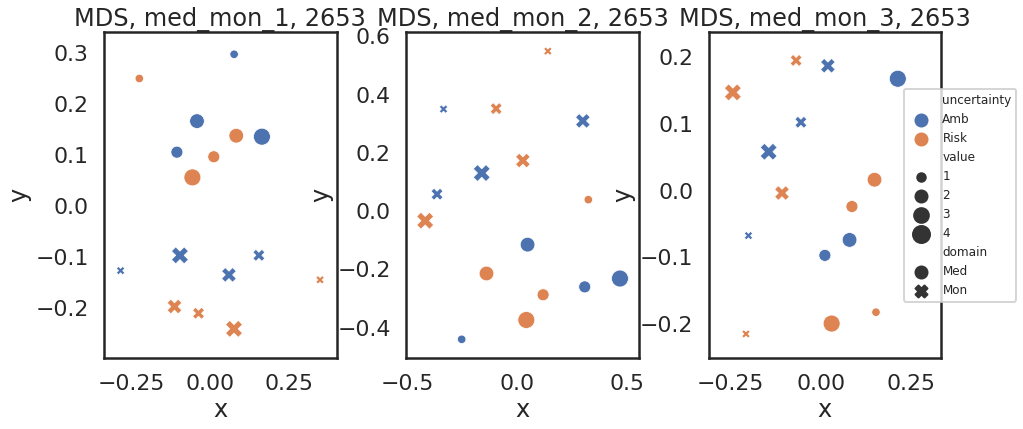

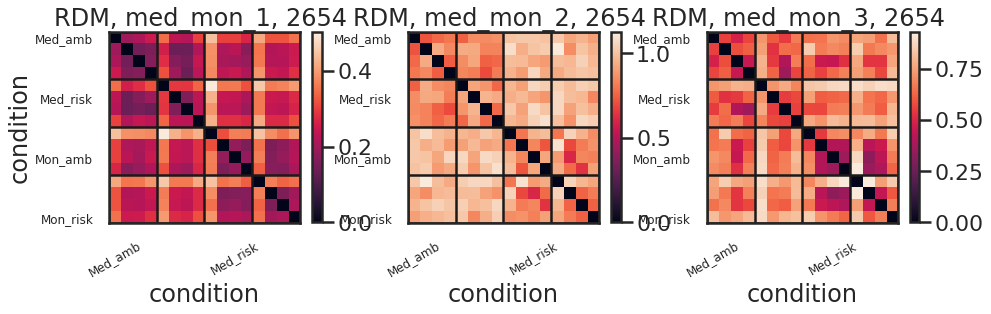

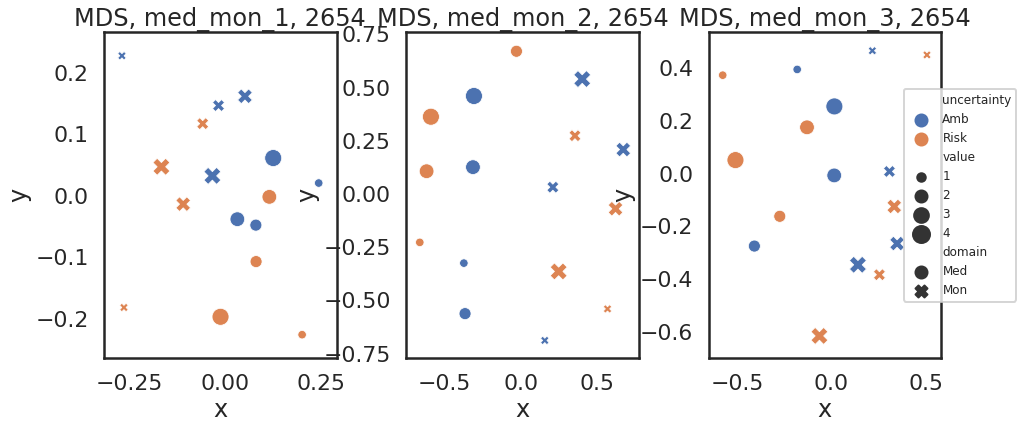

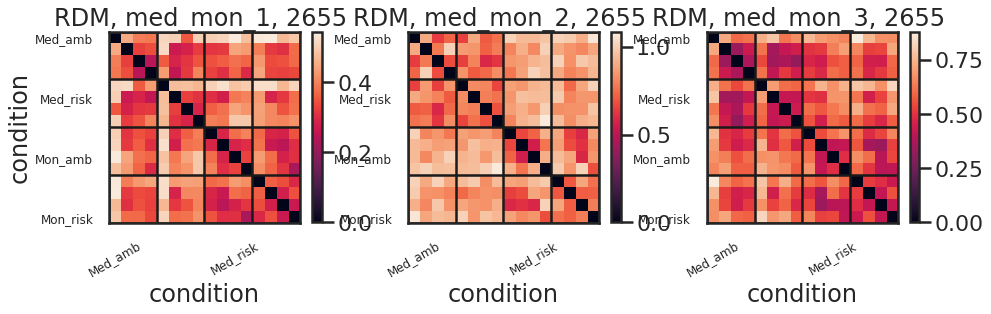

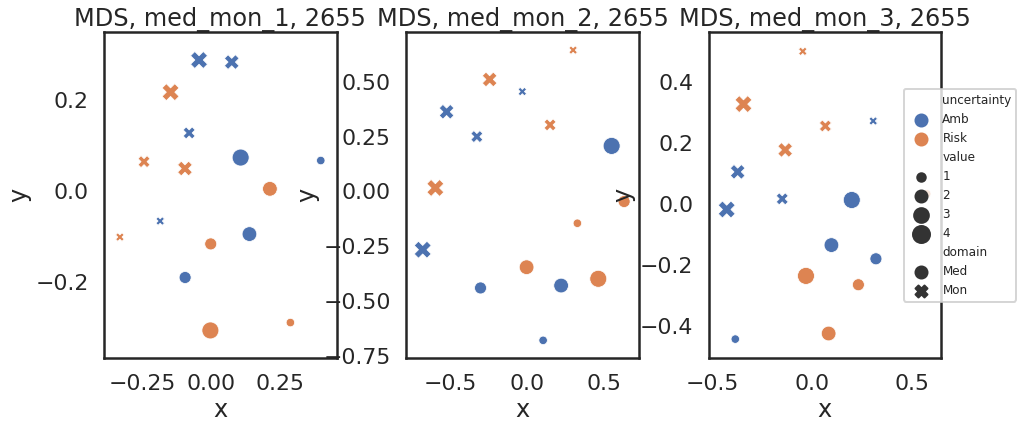

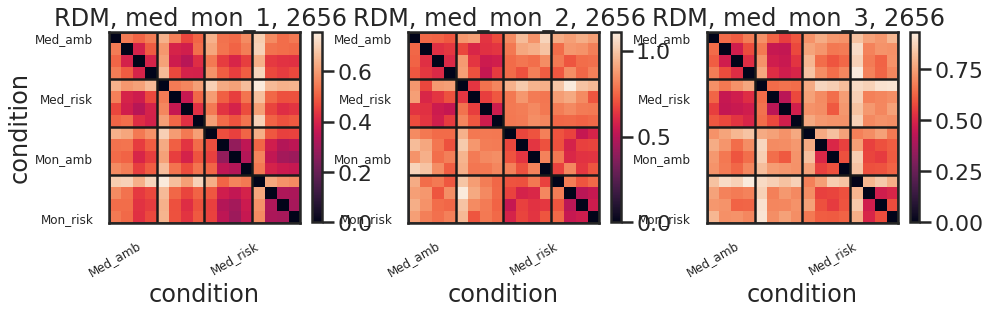

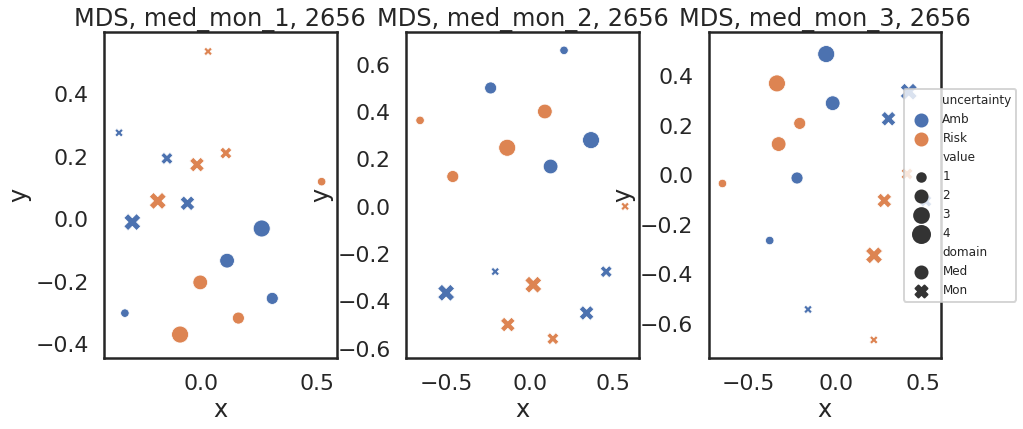

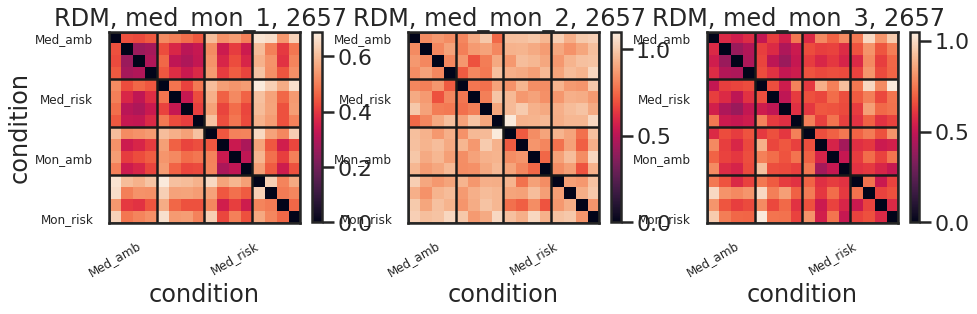

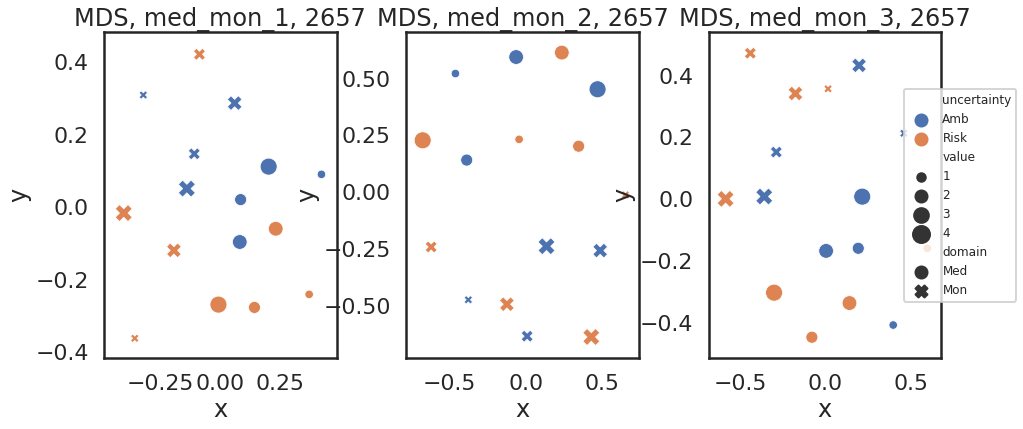

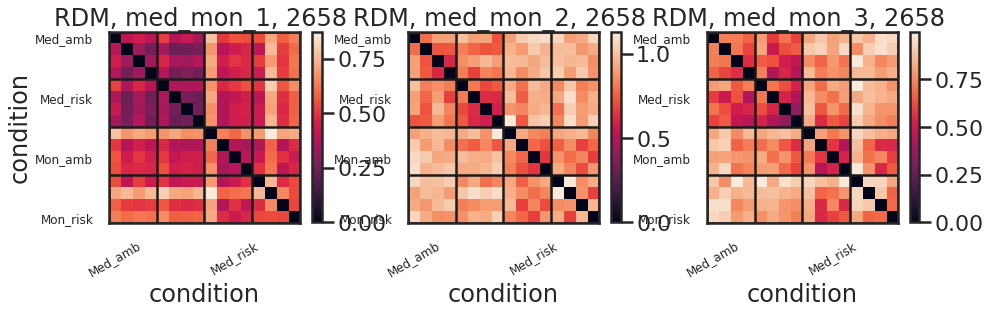

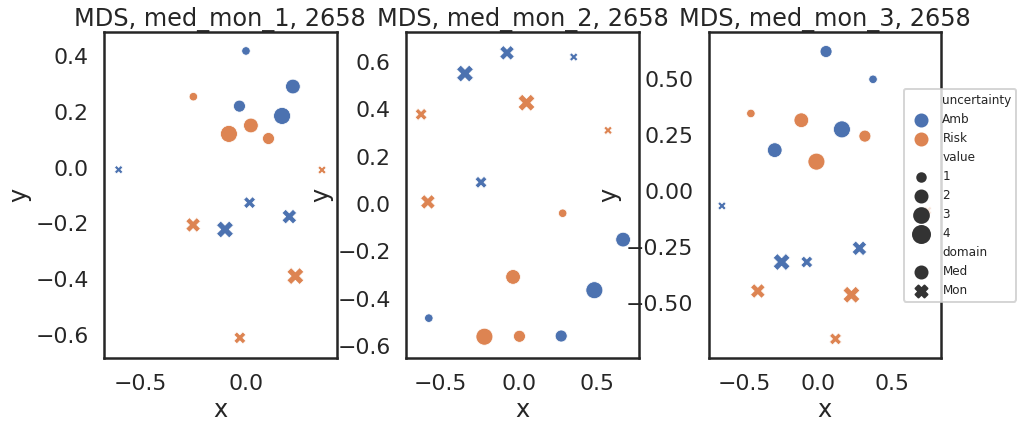

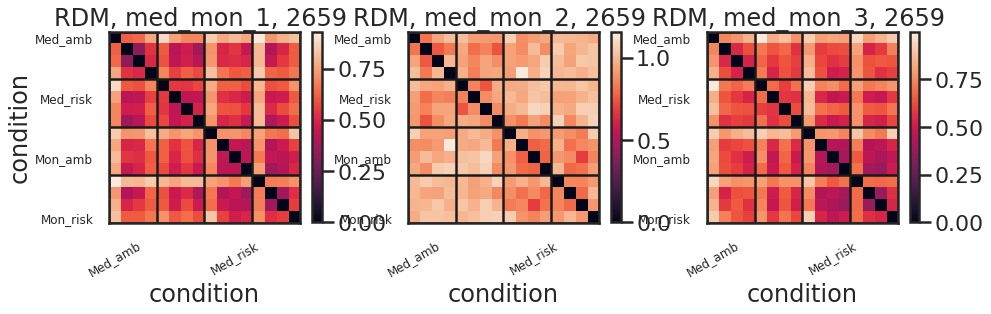

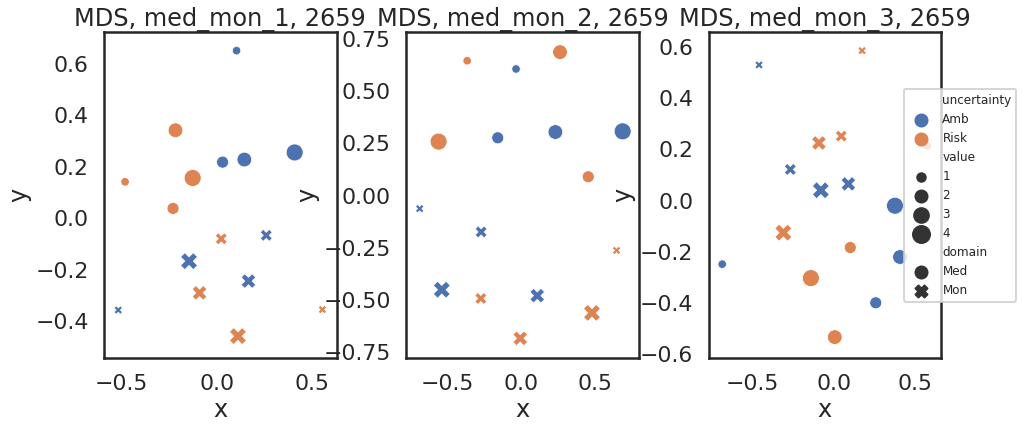

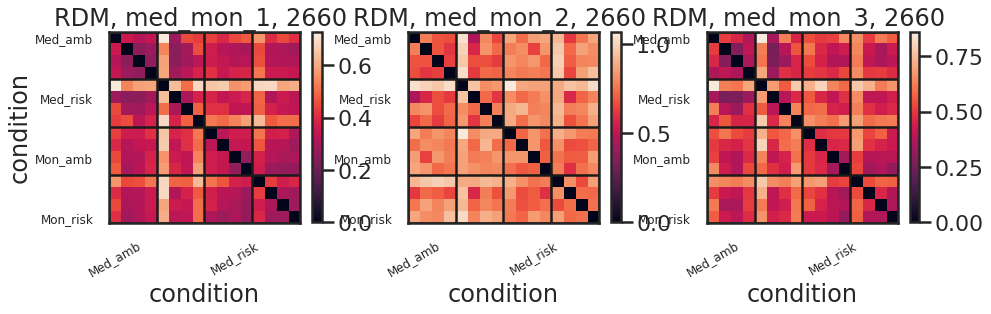

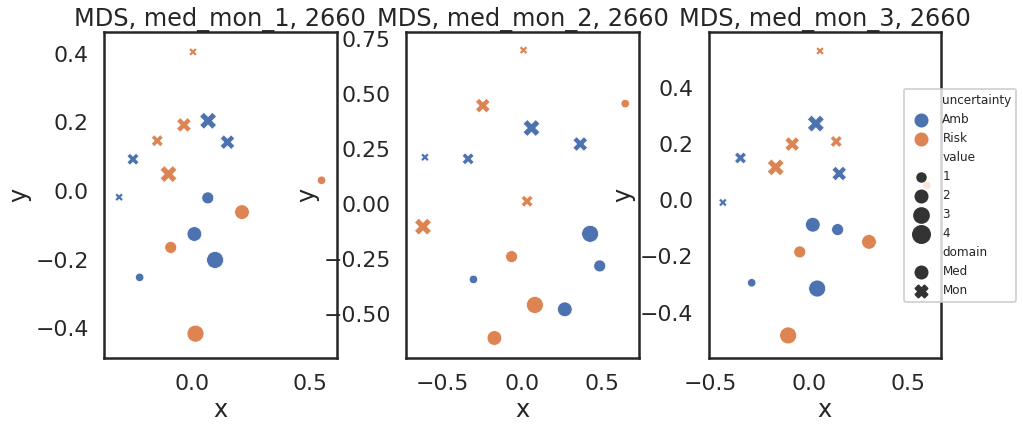

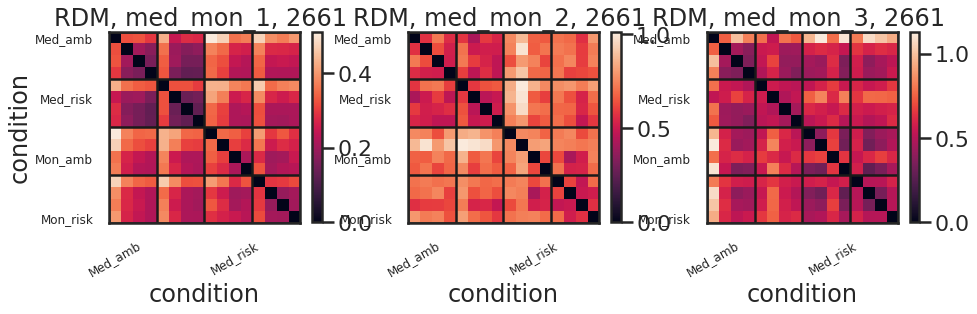

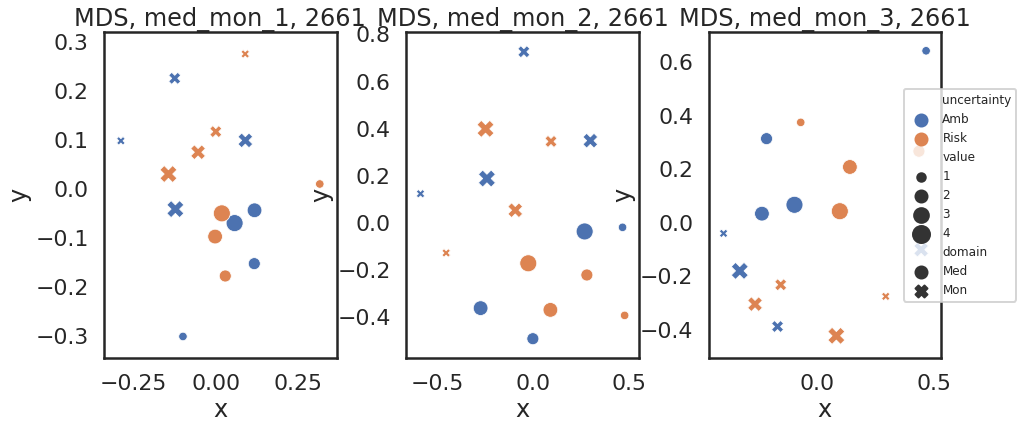

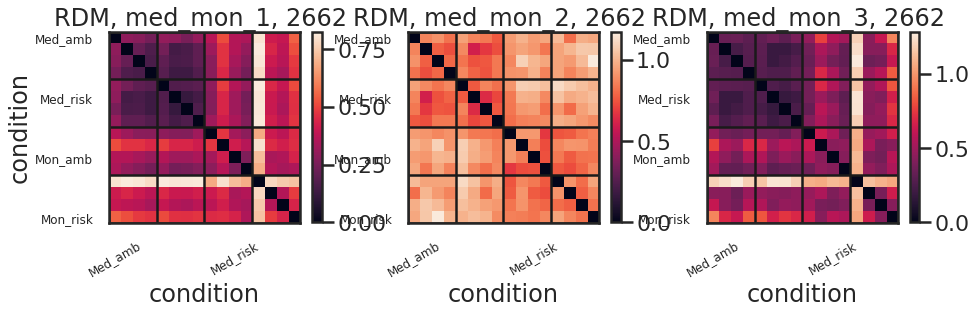

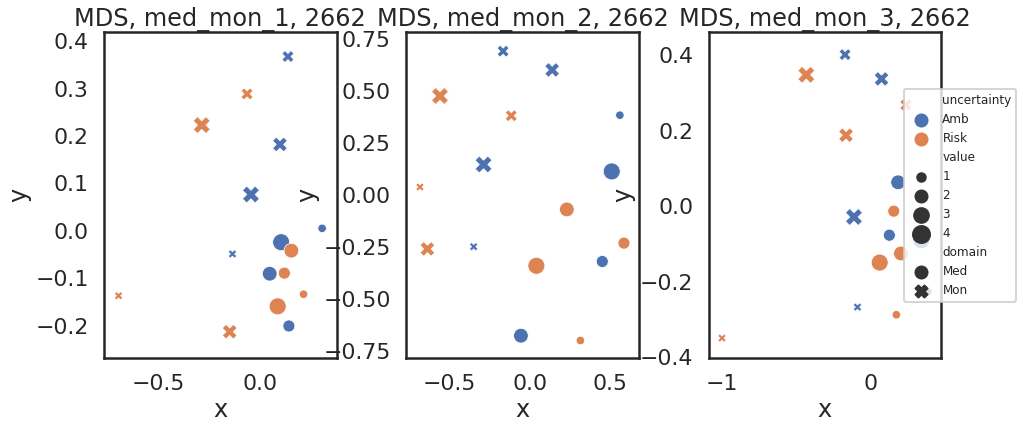

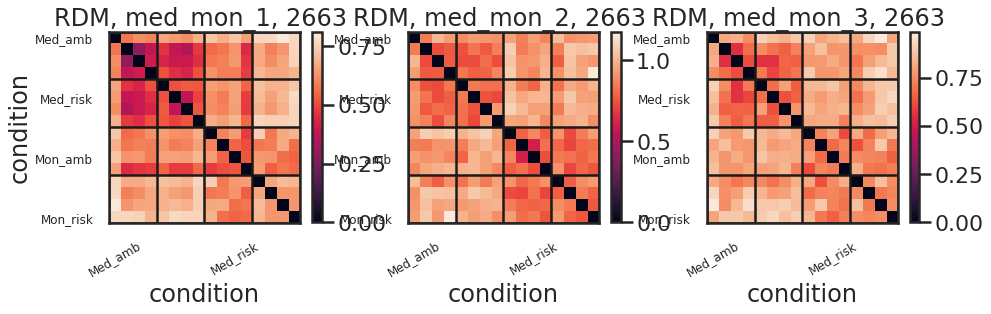

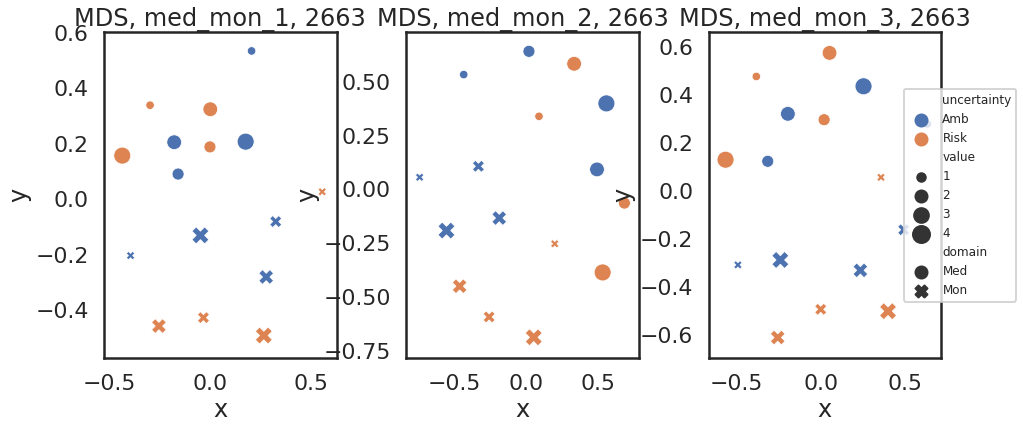

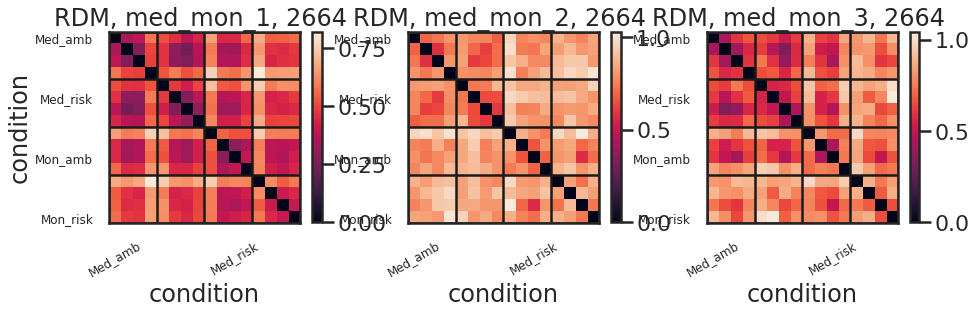

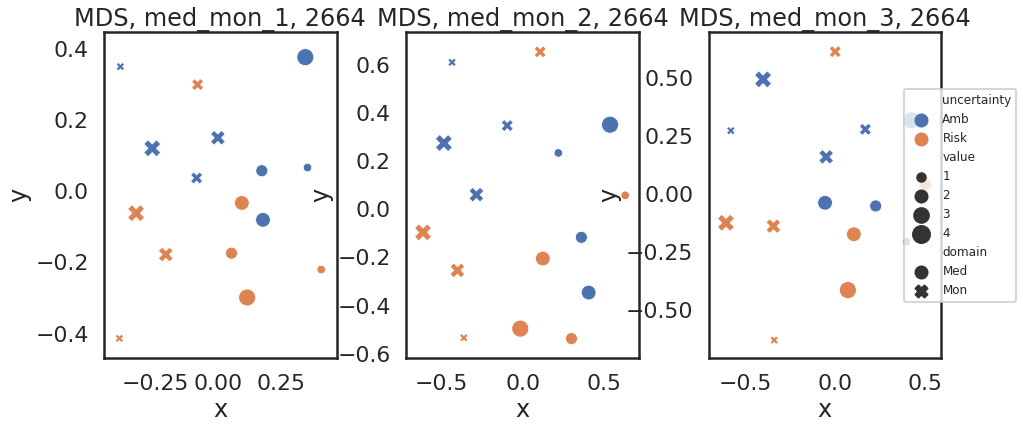

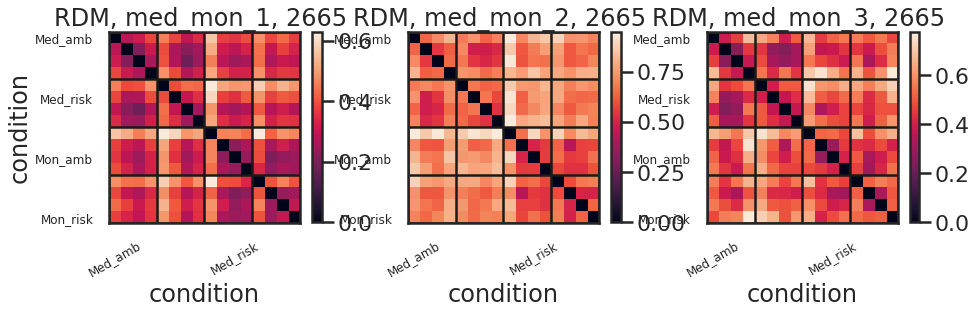

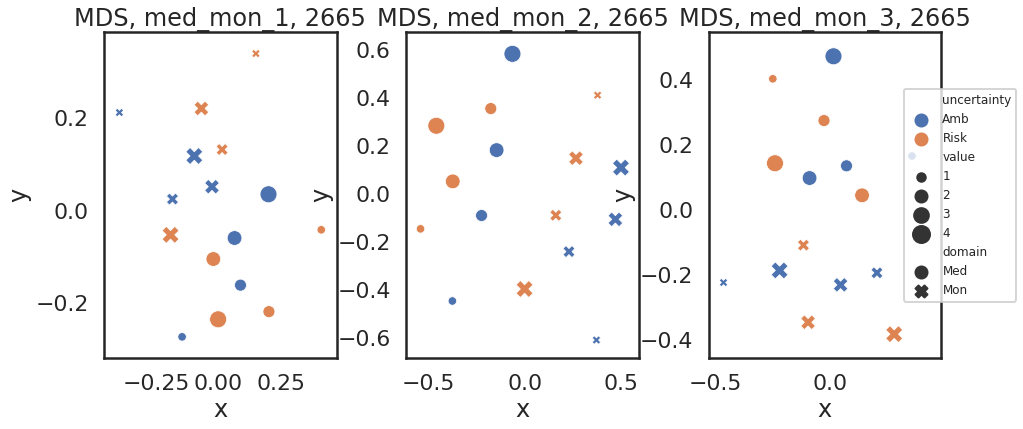

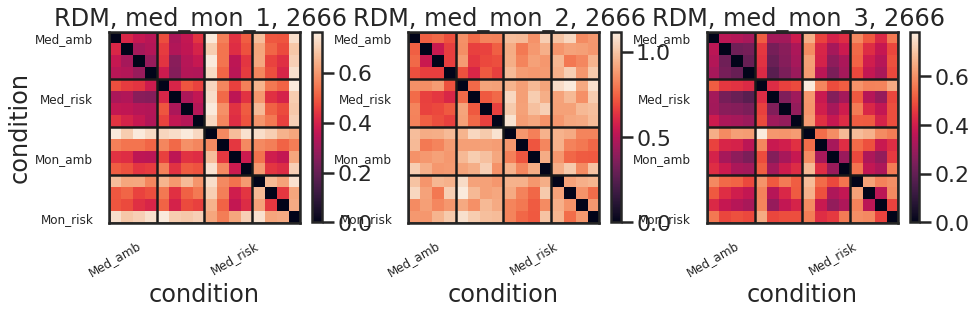

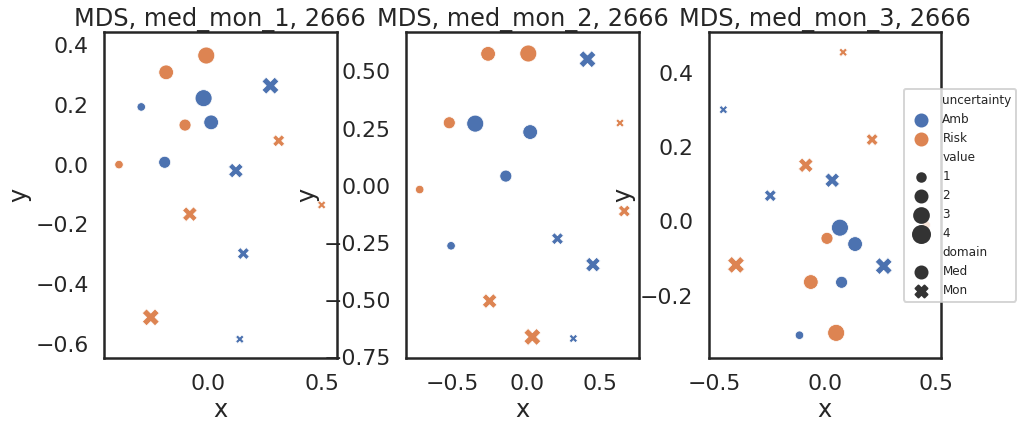

In [31]:
# every subject
roi_names = ['med_mon_1', 'med_mon_2', 'med_mon_3']
subjects = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 
            2593, 2594, 2596, 2597, 2598, 2599, 2600, 2624, 
            2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 
            2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666]

for sub in subjects:
    roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
           allow_pickle = True)

    roi_rdm = roi_rdm_obj.item()

    stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
    fontdict = {'fontsize': 12}
    edges = np.array([0,4,8,12,16])-0.5
#     roi_names = list(roi_rdm.keys())

    f, ax = plt.subplots(1,len(roi_names), figsize=(15, 7))

    for roi_idx in range(len(roi_names)):
        im = ax[roi_idx].imshow(roi_rdm[roi_names[roi_idx]])
        ax[roi_idx].set_xticklabels(stim_cat, rotation = 30, fontdict = fontdict)
        ax[roi_idx].set_yticklabels(stim_cat, fontdict = fontdict)
        ax[roi_idx].set_title('RDM, '+roi_names[roi_idx] + ', %s ' %sub) 
        ax[roi_idx].set_xlabel('condition')
        if roi_idx == 0:
            ax[roi_idx].set_ylabel('condition')
        else:
            ax[roi_idx].set_ylabel('')
        ax[roi_idx].vlines(edges,min(edges),max(edges))
        ax[roi_idx].hlines(edges,min(edges),max(edges))
        f.colorbar(im, ax=ax[roi_idx], shrink = 0.5)


    f.subplots_adjust(wspace = 0.25)
    
    f1, ax1 = plt.subplots(1,len(roi_names), figsize=(15, 6))
    
    for (roi_idx, roi_name) in enumerate(roi_names):
        # Create the MDS object
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
        results = mds.fit(roi_rdm[roi_name])

        coords = results.embedding_

        value = [1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4] 
        uncert = ['Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk',
                  'Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk']
        domain = ['Med','Med','Med','Med','Med','Med','Med','Med',
                  'Mon','Mon','Mon','Mon','Mon','Mon','Mon','Mon']

        mds_coord = pd.DataFrame({'x': coords[:,0], 'y': coords[:,1], 'value': value,
                    'uncertainty': uncert, 'domain': domain})    


        sns.scatterplot(x='x', y = 'y',
                        size = 'value', hue = 'uncertainty', style = 'domain',
                        data=mds_coord, legend = 'full',
                        ax = ax1[roi_idx])
        
        if roi_idx == len(roi_names)-1:
            ax1[roi_idx].legend(fontsize = 12, markerscale = 1, loc = 'right', bbox_to_anchor=(1.35, .5))
        else:
            ax1[roi_idx].legend().remove()
            
        ax1[roi_idx].set_title('MDS, ' + roi_name + ', %s' %sub);
        
    f1.subplots_adjust(wspace = 0.3)

## Visualize group average RDM <a class="anchor" id="grouprdm-bullet"></a>

In [33]:
# get subject average rdm
subjects = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 
            2593, 2594, 2596, 2597, 2598, 2599, 2600, 2624, 
            2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 
            2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666]

roi_names = ['med_mon_1', 'med_mon_2', 'med_mon_3']
# roi_rdm_0 = []
# roi_rdm_1 = []

roi_rdm = {}

for roi_name in roi_names:
    roi_rdm[roi_name] = []

for sub in subjects:
    roi_rdm_sub_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
       allow_pickle = True)
    
    roi_rdm_sub = roi_rdm_sub_obj.item()
#     roi_names = list(roi_rdm_sub.keys())
    
    for roi_name in roi_names:
        roi_rdm[roi_name].append(roi_rdm_sub[roi_name])
    
# roi_rdm = {roi_names[0]: roi_rdm_0, roi_names[1]: roi_rdm_1}    

In [34]:
print('Number of subjects: %s' %len(roi_rdm[roi_names[0]]))
print('Size of RDM:', np.mean(roi_rdm[roi_names[0]], axis = 0).shape)

Number of subjects: 33
Size of RDM: (16, 16)


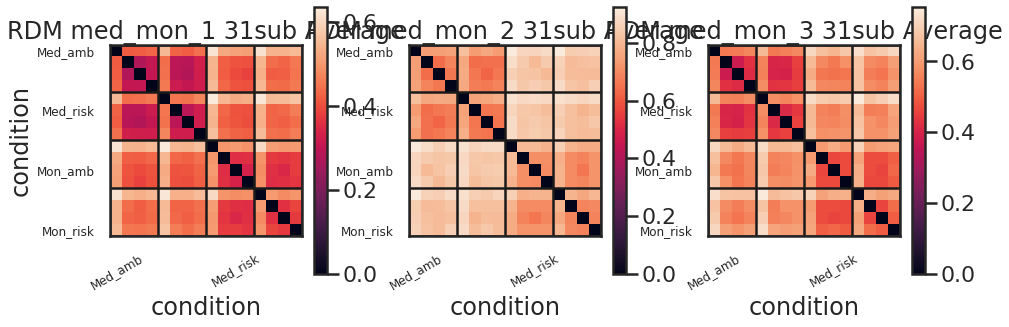

In [35]:
stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 12}
edges = np.array([0,4,8,12,16])-0.5
# roi_names = list(roi_rdm.keys())

f, ax = plt.subplots(1,len(roi_names), figsize=(15, 7))

for roi_idx in range(len(roi_names)):
    im = ax[roi_idx].imshow(np.mean(roi_rdm[roi_names[roi_idx]], axis=0))
    ax[roi_idx].set_xticklabels(stim_cat, rotation = 30, fontdict = fontdict)
    ax[roi_idx].set_yticklabels(stim_cat, fontdict = fontdict)
    ax[roi_idx].set_title('RDM '+roi_names[roi_idx] + ' 31sub Average') 
    ax[roi_idx].set_xlabel('condition')
    if roi_idx == 0:
        ax[roi_idx].set_ylabel('condition')
    else:
        ax[roi_idx].set_ylabel('')
    ax[roi_idx].vlines(edges,min(edges),max(edges))
    ax[roi_idx].hlines(edges,min(edges),max(edges))
    f.colorbar(im, ax=ax[roi_idx], shrink = 0.7)


f.subplots_adjust(wspace = 0.25)

## Multidimentional scaling to visualize the distance between stimuli

In [37]:
# from sklearn.manifold import MDS

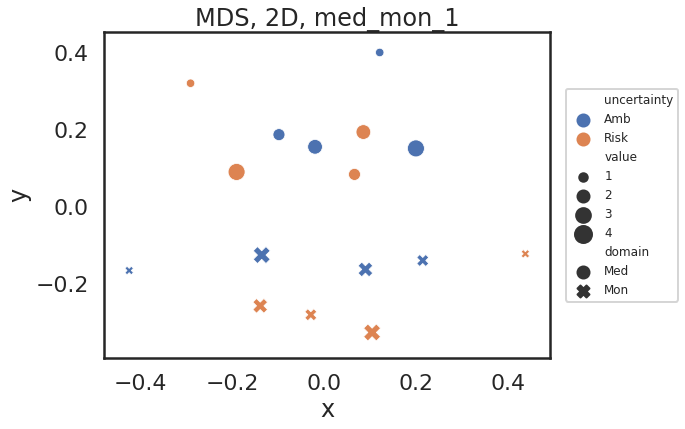

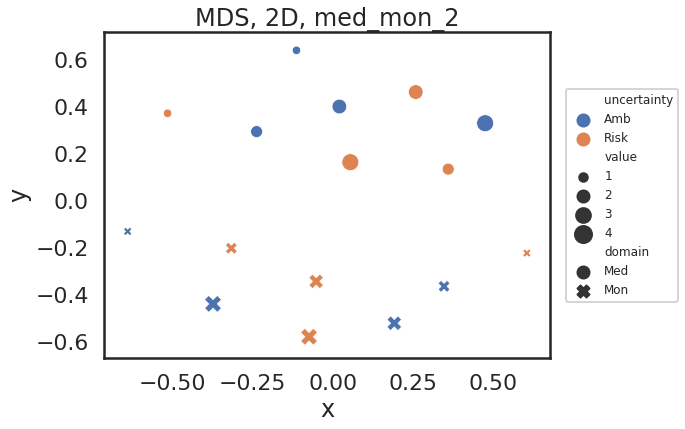

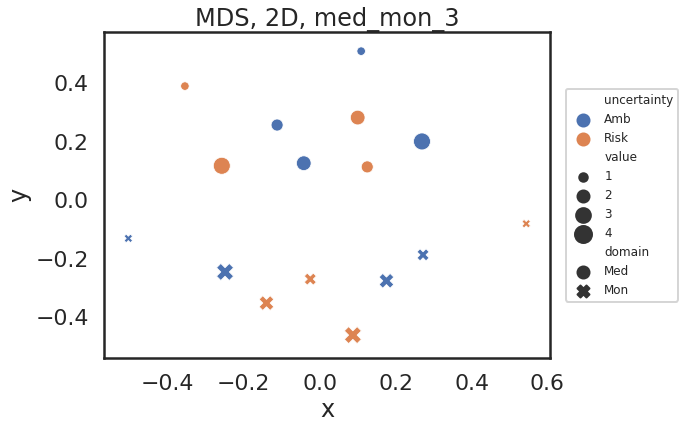

In [36]:
roi_rdm_mean = {}
for roi_name in roi_names:
    roi_rdm_mean[roi_name] = np.mean(roi_rdm[roi_name], axis=0)

for roi_name in roi_names:
    # Create the MDS object
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
    results = mds.fit(roi_rdm_mean[roi_name])
    
    coords = results.embedding_

    value = [1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4] 
    uncert = ['Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk',
              'Amb','Amb','Amb','Amb','Risk','Risk','Risk','Risk']
    domain = ['Med','Med','Med','Med','Med','Med','Med','Med',
              'Mon','Mon','Mon','Mon','Mon','Mon','Mon','Mon']

    mds_coord = pd.DataFrame({'x': coords[:,0], 'y': coords[:,1], 'value': value,
                'uncertainty': uncert, 'domain': domain})    

    f, ax = plt.subplots(1,1,figsize=(8, 6))
    ax = sns.scatterplot(x='x', y = 'y', 
                         size = 'value', hue = 'uncertainty', style = 'domain',
                         data=mds_coord, legend = 'full')
    plt.legend(fontsize = 12, markerscale = 1, loc = 'right', bbox_to_anchor=(1.3, .5))
    plt.title('MDS, 2D,' + ' ' + roi_name);

## Model RDM <a class="anchor" id="modelrdm-bullet"></a>

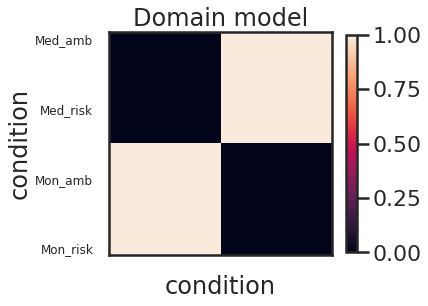

In [103]:
# Model RDM domain difference
mod_rdm_domain = np.ones([16,16])

med_id = list(range(8))
mon_id = list(range(8,16))

mon_mask = [(a,b) for a in mon_id for b in mon_id]
med_mask = [(a,b) for a in med_id for b in med_id]

for mon_mask_idx in mon_mask:  
    mod_rdm_domain[mon_mask_idx] = 0
for med_mask_idx in med_mask:  
    mod_rdm_domain[med_mask_idx] = 0

stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 12}
edges = np.array([0,4,8,12,16])-0.5

f, ax = plt.subplots(1,1, figsize=(5, 5))
im0 = ax.imshow(mod_rdm_domain)
ax.set_xticklabels([])
ax.set_yticklabels(stim_cat, fontdict = fontdict)
ax.set_title('Domain model') 
ax.set_ylabel('condition')
ax.set_xlabel('condition')
# ax.vlines(edges,min(edges),max(edges))
# ax.hlines(edges,min(edges),max(edges))
f.colorbar(im0, ax=ax, shrink = 0.8)

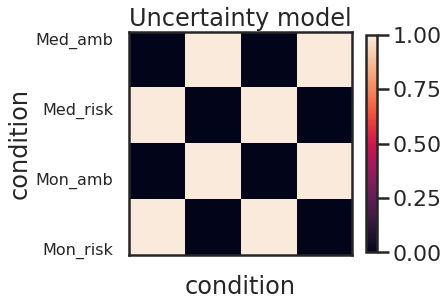

In [104]:
# Model RDM risk/ambig difference
mod_rdm_uncert = np.ones([16,16])

risk_id = [0,1,2,3,8,9,10,11]
amb_id = [4,5,6,7,12,13,14,15]

amb_mask = [(a,b) for a in risk_id for b in risk_id]
risk_mask = [(a,b) for a in amb_id for b in amb_id]

for risk_mask_idx in risk_mask:  
    mod_rdm_uncert[risk_mask_idx] = 0
for amb_mask_idx in amb_mask:  
    mod_rdm_uncert[amb_mask_idx] = 0

stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 16}
edges = np.array([0,4,8,12,16])-0.5

f, ax = plt.subplots(1,1, figsize=(5, 5))
im0 = ax.imshow(mod_rdm_uncert)
ax.set_xticklabels([])
ax.set_yticklabels(stim_cat, fontdict = fontdict)
ax.set_title('Uncertainty model') 
ax.set_xlabel('condition')
ax.set_ylabel('condition')
# ax.vlines(edges,min(edges),max(edges))
# ax.hlines(edges,min(edges),max(edges))
f.colorbar(im0, ax=ax, shrink = 0.8)

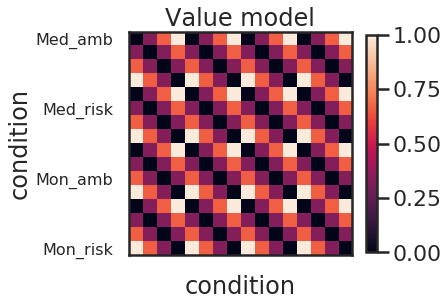

In [105]:
# Model RDM value (outcome magnitude) difference
mod_rdm_val = np.ones([16,16])

level = np.array([0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3])

for i in range(len(level)):
    for j in range(len(level)):
        mod_rdm_val[i, j] = abs(level[i] - level[j])/3
        
stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 16}
edges = np.array([0,4,8,12,16])-0.5

f, ax = plt.subplots(1,1, figsize=(5, 5))
im0 = ax.imshow(mod_rdm_val)
ax.set_xticklabels([])
ax.set_yticklabels(stim_cat, fontdict = fontdict)
ax.set_title('Value model') 
ax.set_xlabel('condition')
ax.set_ylabel('condition')
# ax.vlines(edges,min(edges),max(edges))
# ax.hlines(edges,min(edges),max(edges))
f.colorbar(im0, ax=ax, shrink = 0.8)        

## Model comparison <a class="anchor" id="modelcompare-bullet"></a>

In [102]:
def half_matrix(matrix):
    ''' Take half of the correlation matrix, excluding diagnoal
    Input:
        matrix
    
    Output:
        half_matrix: matrix with the upper half and diagnal equals to nan
        vector: vector of the half matrix, without nan
    '''
    import copy
    
    half_matrix = copy.deepcopy(matrix)
    
    vector = []
    for i in range(half_matrix.shape[0]):
        for j in range(half_matrix.shape[1]):
            if i-j <= 0:
                half_matrix[i,j] = np.nan
            else:
                vector.append(half_matrix[i,j])
    
    return half_matrix, np.array(vector)

In [106]:
# single subject
subjects = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 
            2593, 2594, 2596, 2597, 2598, 2600, 2624, 2650, 
            2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 
            2659, 2660, 2662, 2663, 2664, 2665, 2666]

# subjects = [2073]

# all models to compare
mod_rdm = {'domain': mod_rdm_domain, 'uncertainty': mod_rdm_uncert, 
          'value': mod_rdm_val}
# vectorize
# mod_rdm_vector = {mod_name: 
#                   mod_rdm[mod_name].reshape(mod_rdm[mod_name].shape[0]*mod_rdm[mod_name].shape[1],)
#                   for mod_name in list(mod_rdm.keys())} 

mod_rdm_vector = {}
for mod_name in mod_rdm.keys():
    _, mod_rdm_vector[mod_name] = half_matrix(mod_rdm[mod_name])


In [95]:
roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_rsa/rdm/_subject_id_2599/roi_rdm.npy',
               allow_pickle = True)

In [96]:
test_mat = roi_rdm_obj.item()['vmpfc']

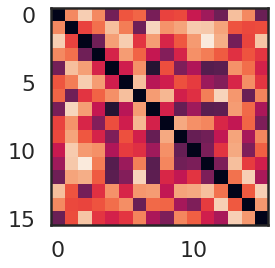

In [97]:
plt.imshow(test_mat)

In [98]:
half_mat, vect = half_matrix(test_mat)

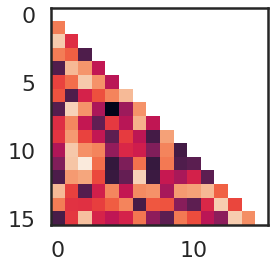

In [99]:
plt.imshow(half_mat)

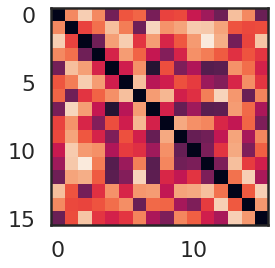

In [100]:
plt.imshow(test_mat)

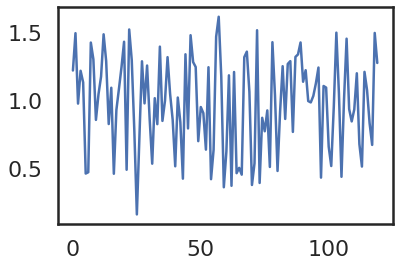

In [101]:
plt.plot(vect)

In [110]:
# calculate spearman correlation between rdm and model rdm
# for each model, each roi, each subject

spearman_r = {'domain': {}, 'uncertainty': {}, 'value': {}}
spearman_p = {'domain': {}, 'uncertainty': {}, 'value': {}}

for (mod_idx, mod_name) in enumerate(list(mod_rdm_vector.keys())):
    
    spearman_r_mod = {'vmpfc': [], 'vstr': []}
    spearman_p_mod = {'vmpfc': [], 'vstr': []}

    for sub in subjects:
        roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_rsa/rdm/_subject_id_%s/roi_rdm.npy' %sub,
               allow_pickle = True)
        
        # get dictionary type
        roi_rdm = roi_rdm_obj.item()

        roi_names = list(roi_rdm.keys())

        for (roi_idx, roi_name) in enumerate(roi_names):
            # spearman bween model rdm and individual rdm, using only half of matrix
            rdm_half, rdm_vector = half_matrix(roi_rdm[roi_name])
            
            rho, pvalue = stats.spearmanr(rdm_vector, mod_rdm_vector[mod_name])
    
            spearman_r_mod[roi_name].append(rho)
            spearman_p_mod[roi_name].append(pvalue)
            
    spearman_r[mod_name] = spearman_r_mod
    spearman_p[mod_name] = spearman_p_mod

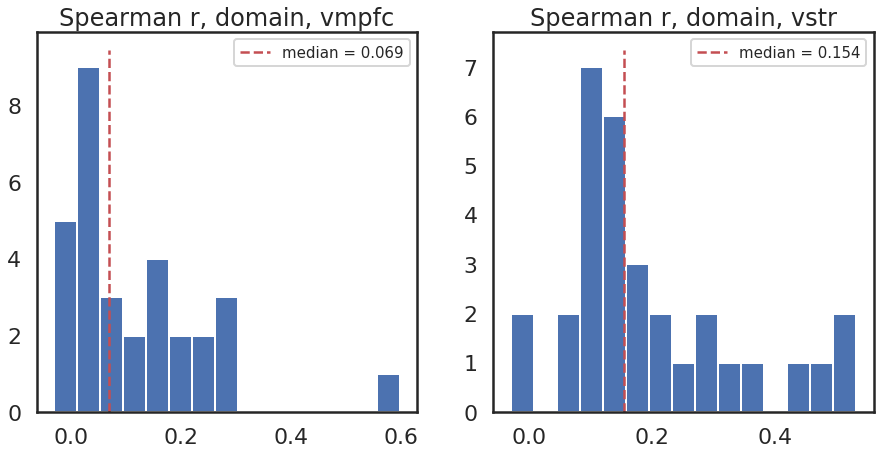

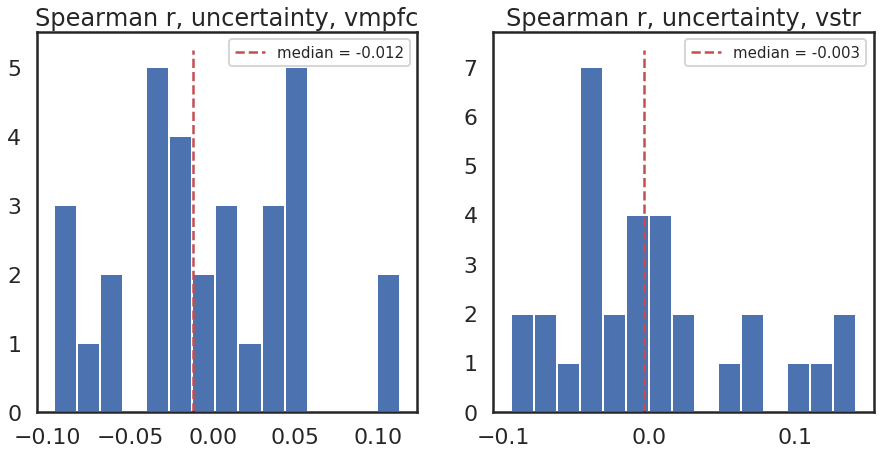

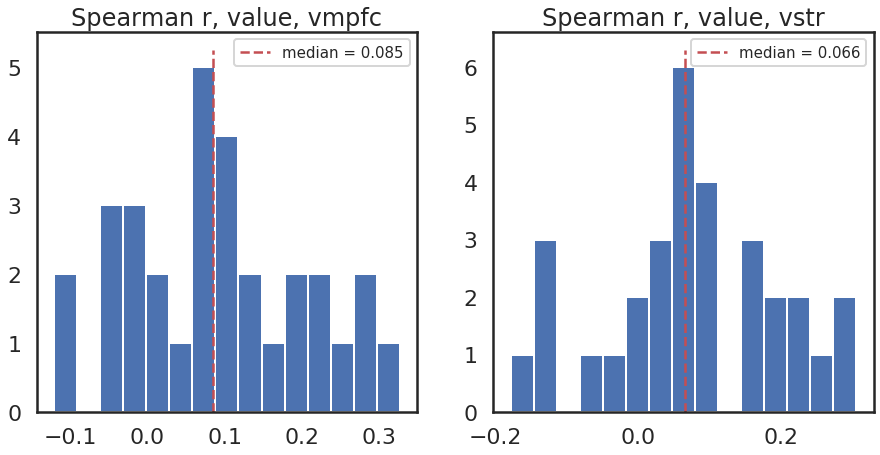

In [111]:
# plot spearman r distribution
for (mod_idx, mod_name) in enumerate(list(mod_rdm_vector.keys())):
    
    f, ax = plt.subplots(1, len(roi_names), figsize = (15,7))
    for (roi_idx, roi_name) in enumerate(roi_names):
        # plot distribution
        ax[roi_idx].hist(spearman_r[mod_name][roi_name], bins = 15)
        # plot median
        median = np.median(spearman_r[mod_name][roi_name])
        ax[roi_idx].vlines(median, ymin=0, ymax=ax[roi_idx].get_ylim()[1], 
                           colors = 'r', linestyles = 'dashed')
        ax[roi_idx].legend(['median = %s' %round(median,3)], fontsize = 15)
        ax[roi_idx].set_title('Spearman r, '+mod_name+', '+roi_name)
        

In [52]:
rdm = np.array(
    [[1,2,3], [4,5,6], [7,8,9]]
)
rdm_perm = np.random.shuffle(rdm)

In [54]:
rdm

array([[7, 8, 9],
       [4, 5, 6],
       [1, 2, 3]])

In [113]:
# permutation test
# for each iteration (iter_num), select perm_num subjects, calculate median
# each permutation: calculate spearman correlation between rdm and model rdm
# do this for each model, each roi

iter_num = 1000 # number of iteration
perm_num = 100 # number of subjects (permutation)
spearman_r_perm = {'domain': {}, 'uncertainty': {}, 'value': {}}
roi_names = ['vmpfc', 'vstr']

# each model
for (mod_idx, mod_name) in enumerate(list(mod_rdm_vector.keys())):
    
    spearman_r_perm_mod = {'vmpfc': [], 'vstr': []}
    
    # each ROI
    for (roi_idx, roi_name) in enumerate(roi_names):
        
        for iter_idx in range(iter_num): 
            
            rho_perm = []
            
            for perm_idx in range(perm_num):
                # randomly select a subject
                sub = np.random.choice(subjects)
                roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_rsa/rdm/_subject_id_%s/roi_rdm.npy' %sub,
                                      allow_pickle = True)

                # get dictionary type
                roi_rdm = roi_rdm_obj.item()
                
                rdm_perm = roi_rdm[roi_name]
                
                # shuffle columns
                np.random.shuffle(rdm_perm)
                
#                 # permute columns of matrix
#                 columns = list(range(roi_rdm[roi_name].shape(0)))
                
#                 columns_perm = np.random.permutation(columns)
                
#                 rdm_perm = np.argsort(columns_perm)
                
                # spearman bween model rdm and individual rdm, half matrix
                _, rdm_vector_perm = half_matrix(rdm_perm)

#                 rdm_vector_perm = np.random.permutation(rdm_vector)
                rho_i, pvalue_i = stats.spearmanr(rdm_vector_perm, mod_rdm_vector[mod_name])
                
                rho_perm.append(rho_i)
                
            spearman_r_perm_mod[roi_name].append(np.median(rho_perm))

    spearman_r_perm[mod_name] = spearman_r_perm_mod


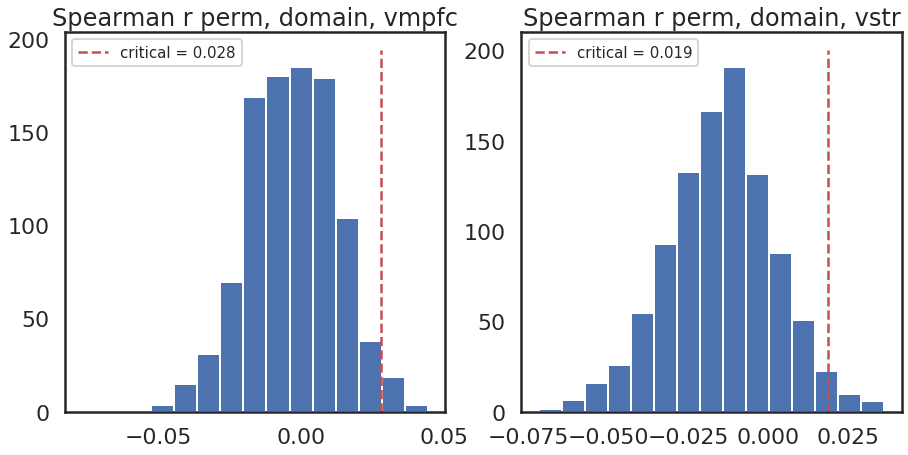

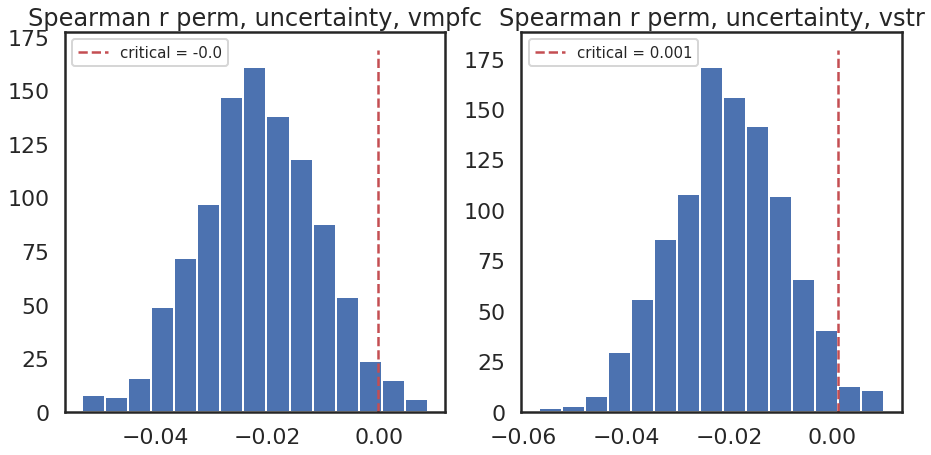

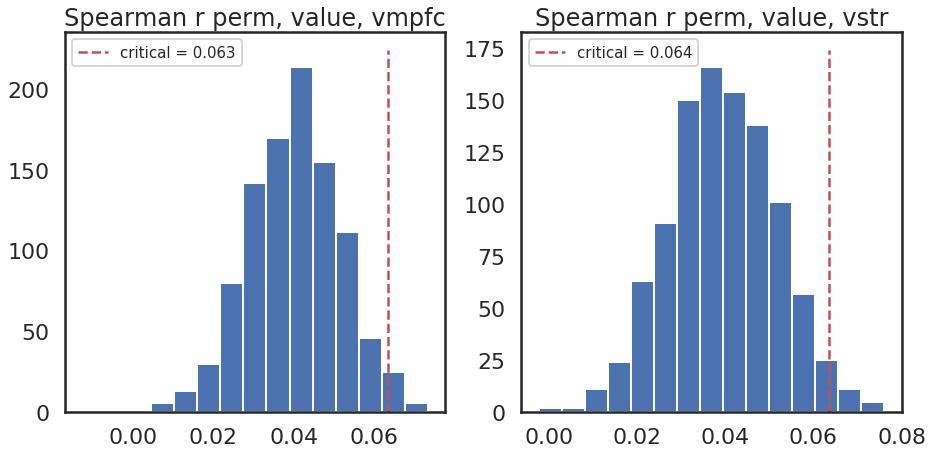

In [114]:
# plot spearman r distribution
sig_level = 0.05

for (mod_idx, mod_name) in enumerate(list(mod_rdm_vector.keys())):
    
    f, ax = plt.subplots(1, len(roi_names), figsize = (15,7))
    for (roi_idx, roi_name) in enumerate(roi_names):
        # plot distribution
        ax[roi_idx].hist(spearman_r_perm[mod_name][roi_name], bins = 15)
        
        # plot critical value
        n_iter = len(spearman_r_perm[mod_name][roi_name])
        # two-tailed
        critical_idx = int(n_iter * (1-sig_level/2))
        r_sorted = np.sort(spearman_r_perm[mod_name][roi_name])
        critical = r_sorted[critical_idx]
        ax[roi_idx].vlines(critical, ymin=0, ymax=ax[roi_idx].get_ylim()[1], 
                           colors = 'r', linestyles = 'dashed')
        ax[roi_idx].legend(['critical = %s' %round(critical,3)], 
                           fontsize = 15,
                          loc = 'upper left')
        
        ax[roi_idx].set_title('Spearman r perm, '+mod_name+', '+roi_name)
        
        